In [2]:
# reload

%load_ext autoreload
%autoreload 2

In [12]:
# import  

#%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import numpy as np
import sys
import math
import scipy.stats as stats
#import wandb
from tqdm import tqdm
import datetime as dt
from functions_dicts_to_parse_data import *
# Increase plot font size from default for all plots instead of setting it in each plot 
plt.rcParams.update({'font.size': 22})

In [4]:
# The dataset we have includes data from all the UEs that are in the network
# So if you want a slice of this dataset that corresponds to one UE (indexed by IMSI) then use this function 

def imsi_slice_data(imsis, data):
    print(sim_time, time_wind_val)
    imsi_slice = np.empty(0)
    for imsi in imsis:
        imsi_slice = np.append(imsi_slice, data[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ])
    return imsi_slice

In [5]:
# redirect all print statements to file instead of console

#file_path = 'logs_from_notebook.txt'
#sys.stdout = open(file_path, "w")

In [6]:
#=========================================
# What info / plots do you want displayed
#=========================================
print_logfile_info = True
print_byte_matrix = True
histogram_plots = True
distance_plots = True
timeseries_plots = True

create_dataset = True
parse_to_plot = False # setting this to false means all plots and prints will be skipped over 

# When using time aggregation to smooth out plots and make them more visually interpretable what window size to use 
time_wind_str = '500ms'
time_wind_val = 500

#===================================
# Data source
#=================================== 
data_dir = '../../data_volume/30_11_power_1000_5_16/'

# This is a subset of log files that we would like to parse and plot at the moment depending on what is in the data 
files = ran_files+[
                   #'dlThroughput_trace.txt',
                   #'rtt_trace.txt', 
                   'delay_trace.txt', 
                   'handover_trace.txt', 'mobility_trace.txt',         
                   'vrBurst_trace.txt', 'vrFragment_trace.txt',
                   'dashClient_trace.txt', 'mpegPlayer_trace.txt', # video streaming
                   'httpServerDelay_trace.txt', 'httpClientDelay_trace.txt', 'httpClientRtt_trace.txt'
                    ]

In [7]:
print('Raw data folder: \n'+data_dir+'\n')
plot_dir = './plots/'+data_dir.split('/')[-2]+'/'
print('Plots saved in folder: \n'+plot_dir+'\n')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Same simulation info is in every run and hence we are showing an arbitrary run 
#info_file = open(data_dir+'run3/simulation_info.txt')
#for i in range(95):
#    print(info_file.readline())

Raw data folder: 
../../data_volume/30_11_power_1000_5_16/

Plots saved in folder: 
./plots/30_11_power_1000_5_16/



  0%|                                                                                                                                                                                                                                                              | 0/26 [00:00<?, ?it/s]

../../data_volume/30_11_power_1000_5_16/run21
+48.171308946s (0.097   x real time) 121099 events processed

This run did not finish to completion, skipping it
['run21']
../../data_volume/30_11_power_1000_5_16/run19
+24.987075381s (0.058   x real time) 145106 events processed

This run did not finish to completion, skipping it
['run21', 'run19']
../../data_volume/30_11_power_1000_5_16/run25
+480.491071543s (0.102   x real time) 122669 events processed

This run did not finish to completion, skipping it
['run21', 'run19', 'run25']
../../data_volume/30_11_power_1000_5_16/run3
+115.300884945s (0.066   x real time) 134454 events processed

This run did not finish to completion, skipping it
['run21', 'run19', 'run25', 'run3']
../../data_volume/30_11_power_1000_5_16/run6
+21.029873996s (0.052   x real time) 115860 events processed

This run did not finish to completion, skipping it
['run21', 'run19', 'run25', 'run3', 'run6']
../../data_volume/30_11_power_1000_5_16/run12
+64.612171681s (0.070 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:26<00:00,  3.32s/it]

Byte Matrix in MB
  X  phy mac rlc pdcp
dlTx  x   x   x   x
ulTx  x   x   x   x
dlRx  x   x   x   x
ulRx  x   x   x   x
[[12050 12050  6176  6328]
 [ 6563  6564  1073  1082]
 [12049     0  6175  6160]
 [ 5716     0  1070  1057]]
../../data_volume/30_11_power_1000_5_16/run14
+248.778852657s (0.080   x real time) 145130 events processed

This run did not finish to completion, skipping it
['run21', 'run19', 'run25', 'run3', 'run6', 'run12', 'run8', 'run15', 'run5', 'run24', 'run18', 'run7', 'run20', 'run11', 'run10', 'run26', 'run14']
../../data_volume/30_11_power_1000_5_16/run17
+55.697516951s (0.074   x real time) 106703 events processed

This run did not finish to completion, skipping it
['run21', 'run19', 'run25', 'run3', 'run6', 'run12', 'run8', 'run15', 'run5', 'run24', 'run18', 'run7', 'run20', 'run11', 'run10', 'run26', 'run14', 'run17']
../../data_volume/30_11_power_1000_5_16/run16
+70.002703788s (0.053   x real time) 236339 events processed

This run did not finish to completion

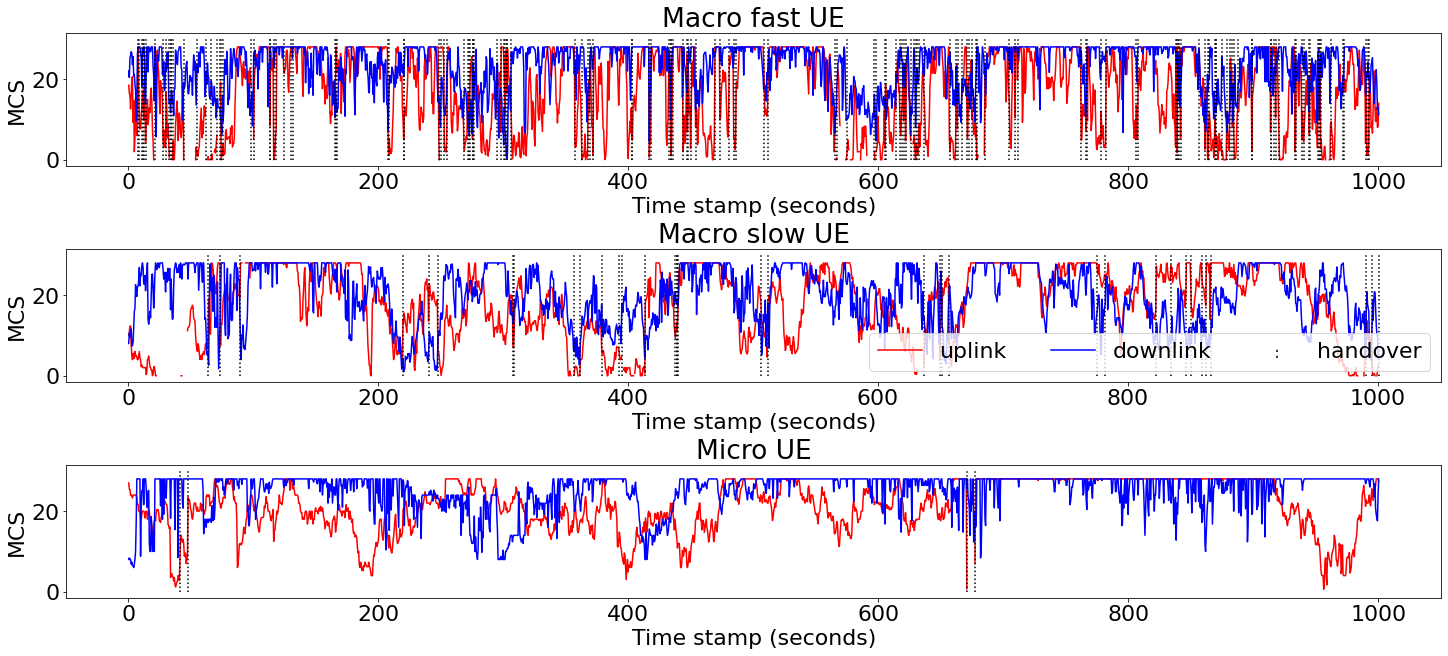

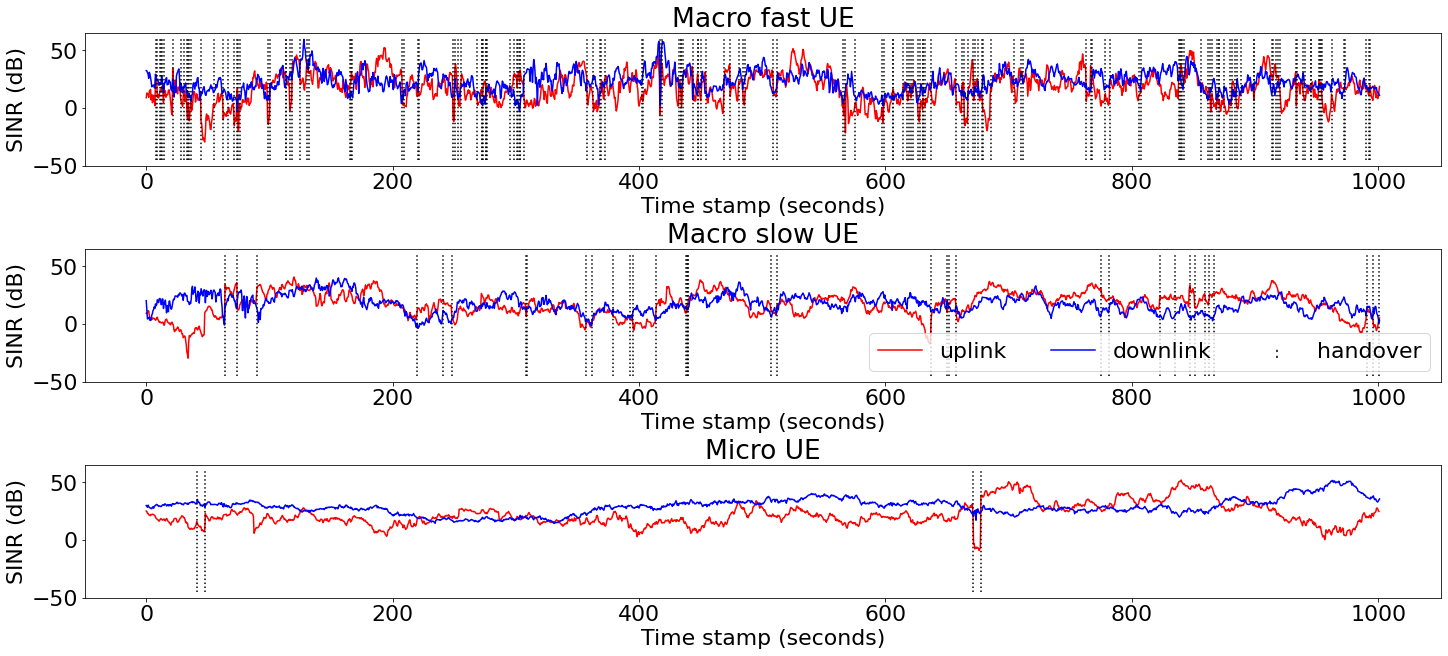

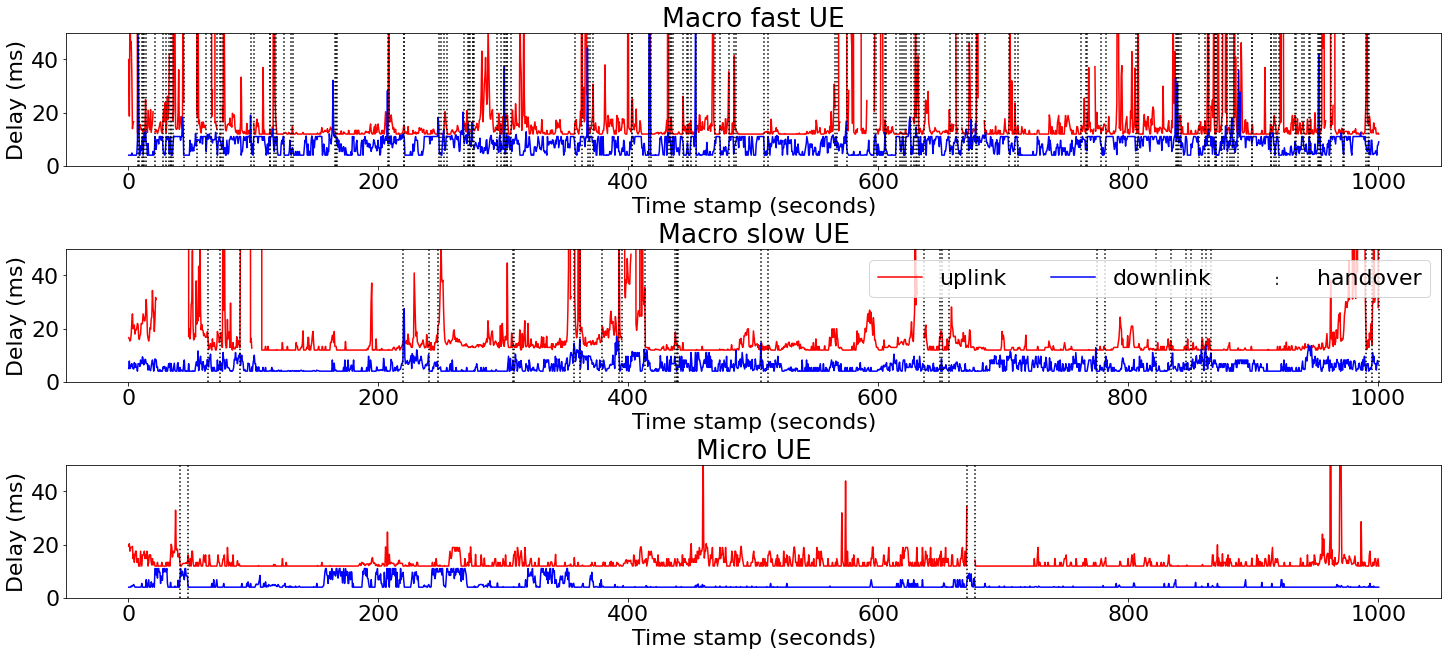

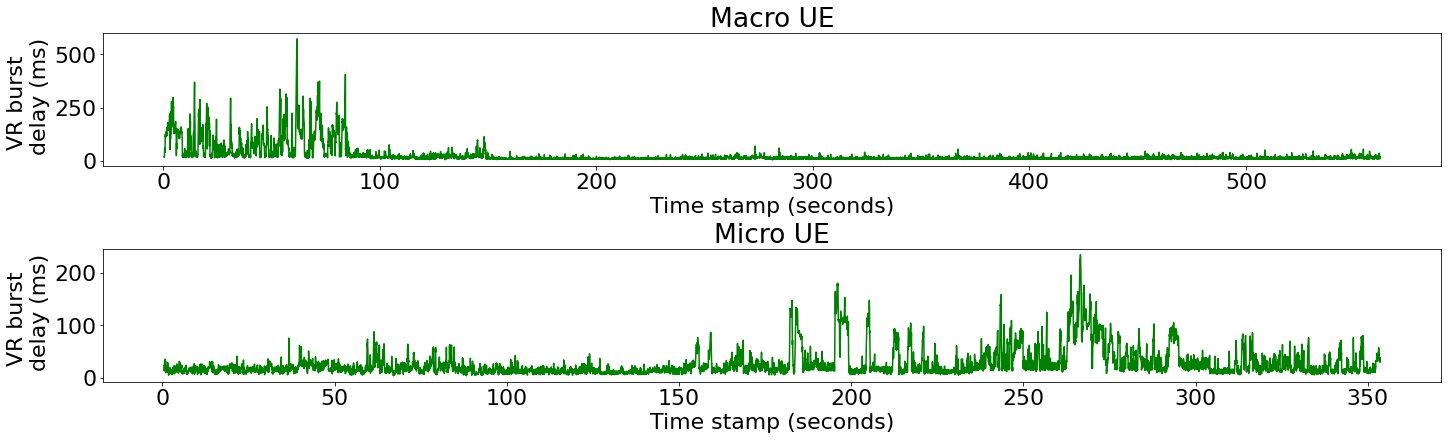

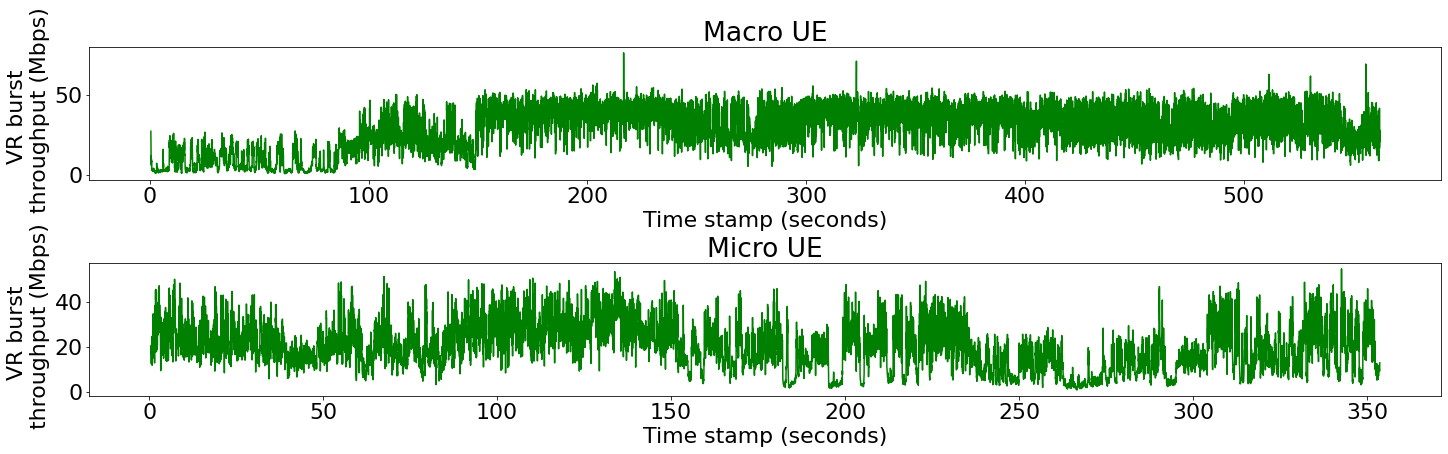

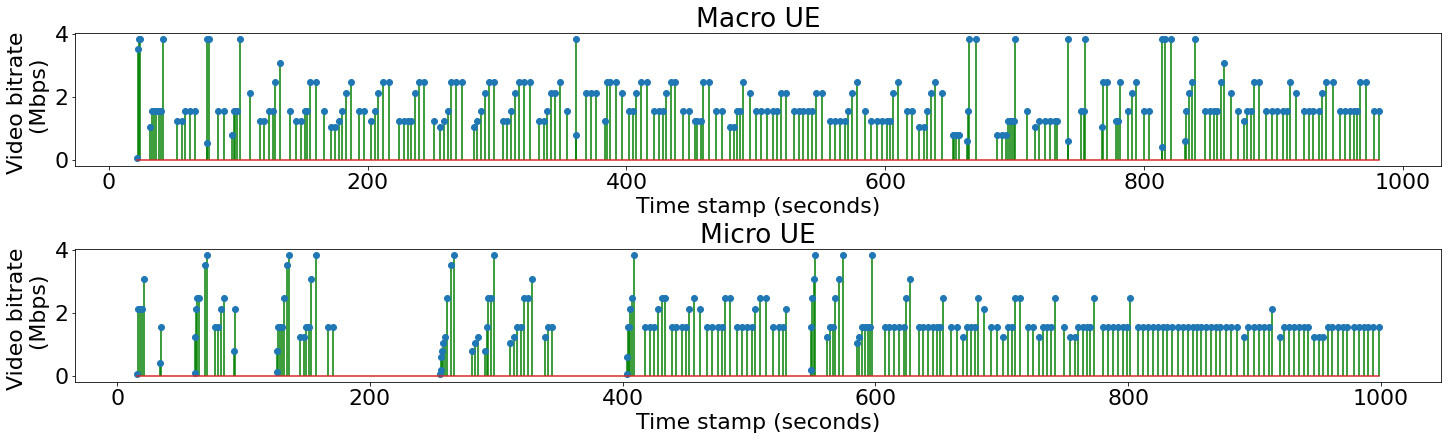

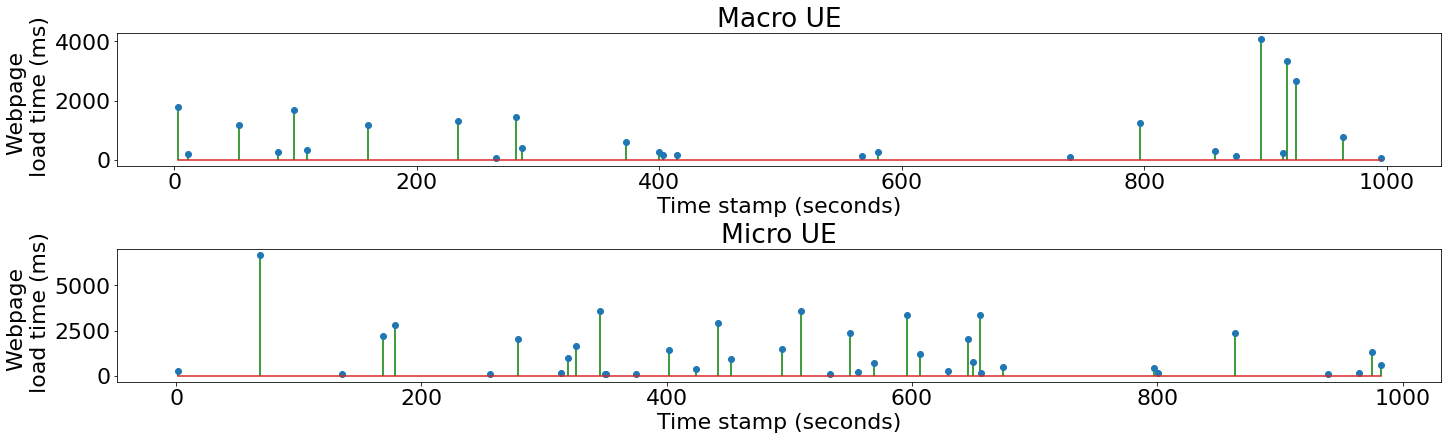

In [ ]:
plt.rcParams["figure.autolayout"] = False
#=======================================
# Initilizing empty lists 
#=======================================
# increment them as we see full runs 
num_runs = 0 
skip_runs = []

# These are values aggregated over all UEs over the símulations time over all runs 
ul_delay_probe_delivery_rate = {'macro': 0, 'micro': 0}
dl_delay_probe_delivery_rate = {'macro': 0, 'micro': 0}
rtt_probe_delivery_rate = {'macro': 0, 'micro': 0}
ul_avg_thput = {'macro': 0, 'micro': 0}
dl_avg_thput = {'macro': 0, 'micro': 0}
hos_per_cell_per_time = 0

# Baselines for empty networks
# Aggregate over UEs and runs for histogram plots
# These are arrays with samples aggregated over all UEs over the simulations time over all runs 
# These are not windowed 
ul_delays = {'macro': np.empty(0), 'micro': np.empty(0)}
dl_delays = {'macro': np.empty(0), 'micro': np.empty(0)}
rtt_delays = {'macro': np.empty(0), 'micro': np.empty(0)}
ul_mcs = {'macro': np.empty(0), 'micro': np.empty(0)}
dl_mcs = {'macro': np.empty(0), 'micro': np.empty(0)}
ul_sinr = {'macro': np.empty(0), 'micro': np.empty(0)}
dl_sinr = {'macro': np.empty(0), 'micro': np.empty(0)}
dl_rsrp = {'macro': np.empty(0), 'micro': np.empty(0)}
rtt_pkt_rx = {'macro': np.empty(0), 'micro': np.empty(0)}
cell_ul_thput = {'macro': np.empty(0), 'micro': np.empty(0)}
cell_dl_thput = {'macro': np.empty(0), 'micro': np.empty(0)}
ul_thput = np.empty(0)
dl_thput = np.empty(0)
time_bw_hos = np.empty(0) # seconds 
# app specific observations for plotting
# aggregated over all UEs running this app to plot histograms 
page_load_time = {'macro': np.empty(0), 'micro': np.empty(0)} # page load time over all webpages viewed 
webpage_size = {'macro': np.empty(0), 'micro': np.empty(0)} # size of the webpage 
segment_bitrate = {'macro': np.empty(0), 'micro': np.empty(0)} # bitrate of segment requested over all videos watched
vr_burst_time = {'macro': np.empty(0), 'micro': np.empty(0)} # time to receive a full burst in VR 
vr_burst_thput = {'macro': np.empty(0), 'micro': np.empty(0)} # thput achieved over a VR burst 
#vr_frag_time = {'macro': np.empty(0), 'micro': np.empty(0)} # time to receive a fragment that is part of a burst in VR 
#vr_frag_thput = {'macro': np.empty(0), 'micro': np.empty(0)} # thput achieved over a VR fragment 


# Baselines for empty networks
# distance to BS versus metrics, aggregated over windows 
# These are arrays with samples aggregated over all UEs over the simulations time over all runs 
# These are windowed 
w_ul_delays = np.empty(0)
w_dl_delays = np.empty(0)
w_rtt_delays = np.empty(0)
w_ul_mcs = np.empty(0)
w_dl_mcs = np.empty(0)
w_ul_sinr = np.empty(0)
w_dl_sinr = np.empty(0)
w_rsrp = np.empty(0)
w_ul_pkt_rx = np.empty(0)
w_dl_pkt_rx = np.empty(0)
w_rtt_pkt_rx = np.empty(0)
w_dist_to_cell = np.empty(0)
w_avg_ue_xpos = np.empty(0)
w_avg_ue_ypos = np.empty(0)
w_mode_assoc_cell = np.empty(0)

# constant multipliers
M = (10**6)
K = (10**3)
#=======================================
# Iterate over runs and files 
#=======================================

run_idx=0
#=================================================================
#use_runs = [13]
#use_runs = range(1,5)
#use_runs_paths = [(data_dir+'run'+str(r)) for r in use_runs]
use_runs_paths = glob.glob(data_dir+'run*')

for run in tqdm(use_runs_paths):
#=================================================================
    print('============================================================')
    print (run)
    print('============================================================')
    only_run = run.split('/')[-1]
    
    # check if run ran to completion
    with open(run+'/simulation_info.txt', "r") as sim_info_file:
        last_line = sim_info_file.readlines()[-1]
        print(last_line)
        if 'Elapsed wall clock' not in last_line:
            print('This run did not finish to completion, skipping it')
            skip_runs.append(only_run)
            print(skip_runs)
            continue
    
    sim_info = pd.read_csv(run+'/sim_info.txt', sep=',').set_index('parameter').to_dict('index')
    # Specify here topology details from the dataset we are using 
    # This can be infered from the files, but this is easier
    print(sim_info)
    separate_macro_micro = bool(int(sim_info['create_micro_layer']['value'])) 
    print('separate_macro_micro ', separate_macro_micro)
    total_num_cells=(int(sim_info['macro_num_bs']['value'])+int(sim_info['micro_num_bs']['value'])) if separate_macro_micro else int(sim_info['macro_num_bs']['value']) 
    print('total_num_cells', total_num_cells)
    total_num_ues=int(sim_info['macro_layer_ues']['value'])+int(sim_info['micro_layer_ues']['value']) if separate_macro_micro else int(sim_info['macro_layer_ues']['value'])
    print('total_num_ues', total_num_ues)
    sim_time = int(sim_info['simulation_time_seconds']['value']) # seconds
    print('sim_time', sim_time)
    
    sim_start_time = pd.to_datetime(0, unit='s', origin='unix')
    sim_end_time = pd.to_datetime(sim_time, unit='s', origin='unix')

    dict_gnb_pos = pd.read_csv(run+'/gnb_locations.txt', sep=',').set_index('cellId').to_dict('index')
    dict_gnb_pos[0] = {'gnbpos_x': np.nan, 'gnbpos_y': np.nan, 'gnbpos_z': np.nan}
    #print(dict_gnb_pos)
    # read UE group list
    ue_groups = open(run+'/ue_gnb_groups.txt').readlines()
    macro_imsis = [int(i) for i in ue_groups[0].split(',')[1:-1]]
    print("Macro UE IMSIs: ", macro_imsis)
    micro_imsis = list(set(range(1, total_num_ues+1)) - set(macro_imsis))
    print("Micro UE IMSIs: ", micro_imsis)
    fast_imsis = [int(i) for i in ue_groups[1].split(',')[1:-1]]
    print("Macro fast UE IMSIs: ", fast_imsis)
    slow_imsis = list(set(range(1, total_num_ues+1)) - set(fast_imsis) - set(micro_imsis))
    print("Macro Slow UE IMSIs: ", slow_imsis)
    #only_delay_imsis=[3,5,7,9,13,15,17,19,23,55,57]
    only_delay_imsis=[int(i) for i in ue_groups[2].split(',')[1:-1]]
    print("Only delay IMSIs: ", only_delay_imsis)
    
    # timeseries plots: Which run should I select for timeseries plots 
    ts_plot_run_idx = 0 # always plot the timeseries for the first run processed
    # Which UEs (or IMSIs) should we make time series plots for from the ts_plot_run_nums runs 
    ts_plot_IMSIs = [list(set(fast_imsis).intersection(only_delay_imsis))[0], 
                     list(set(slow_imsis).intersection(only_delay_imsis))[0]]
    if separate_macro_micro: 
                     ts_plot_IMSIs.append(list(set(micro_imsis).intersection(only_delay_imsis))[0])
    print("Timeseries plotting IMSIs: ", ts_plot_IMSIs)
    
    # Read these from the ue_groups file later and also rename ue_groups to somethign else 
    macro_cells = [1,2,3]
    print('Macro CellIds: ', macro_cells)
    micro_cells = [4,5,6]
    print('Micro CellIds: ', micro_cells)
    
    vr_imsi=np.empty(0)
    dash_imsi=np.empty(0)
    http_imsi=np.empty(0)

    # To store and compare the number of bytes sent and received in different RAN layers 
    bytes_matrix = np.zeros((4, 4), dtype=int)
    # time series plots for a chosen run
    if ts_plot_run_idx == run_idx:
    #if True:    
        # Aggregate plots from different files into one figure since we iterate over files
        # subplots for the chosen IMSI values for the one chosen run 
        # ul mcs, dl mcs figure
        if 'UlMacStats.txt'in files and 'DlMacStats.txt' in files:
            fig_mcs, axs_mcs = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True, squeeze=False)
            #fig_mcs.suptitle(only_run+':  MCS: UL/DL')
        if 'DlRsrpSinrStats.txt' in files and 'UlSinrStats.txt' in files: 
            # ul sinr and dl sinr
            fig_sinr, axs_sinr = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True, squeeze=False)
            #fig_sinr.suptitle(only_run+':  SINR: UL/DL')
        if 'delay_trace.txt' in files:
            # ul delay, dl delay, rtt figure 
            fig_delay, axs_delay = plt.subplots(len(ts_plot_IMSIs),1,figsize=(20,(len(ts_plot_IMSIs)*3)), constrained_layout = True, squeeze=False)
            #fig_delay.suptitle(only_run+':  Delay: UL/DL')
        
        
    
#=================================================================
    for file in files:
#=================================================================
        print('--------------------------------------------')
        print(file)
        start_time = time.time()
        
        #=======================================
        # Preprocess logs 
        #=======================================
        
        ## Read file while fixing the tab issue
        if file in files_with_trailing_tab:
            #df = pd.read_csv(data_dir+run+'/'+file, sep='\t', usecols=range(0,18))
            df = pd.read_csv(run+'/'+file, sep='\t', usecols=range(0,18))
            print(run+'/'+file)
        else:
            #df = pd.read_csv(data_dir+run+'/'+file, sep='\t')
            df = pd.read_csv(run+'/'+file, sep='\t')
            print(run+'/'+file)
        
        print('time to read file: ', (time.time() - start_time))
        
        
        ## Do some file specific preprocessing
        ## Make uniform the timestamp units convert them all to micro seconds 
        if '% time' in df.columns:
            df.rename(columns = {'% time':'tstamp_us'}, inplace = True)
            if file_name_to_tstamp_unit[file] == 'ms':
                df['tstamp_us'] = df['tstamp_us']*K
            elif file_name_to_tstamp_unit[file] == 's':
                df['tstamp_us'] = df['tstamp_us']*M
        ## Make uniform the timestamp units        
        if '% start' in df.columns:
            ## TO DO: check if this is actually micro seconds. I think it is seconds   
            df.rename(columns = {'% start':'tstamp_us'}, inplace = True)
            df.rename(columns = {'end':'end_timeslot_us'}, inplace = True)
            df['tstamp_us'] = df['tstamp_us']*M
            df['end_timeslot_us'] = df['end_timeslot_us']*M
        ## Some internally generated logs use the naming 'CellId' replace that with 'cellId'
        if ('CellId' in df.columns):
            df.rename(columns = {'CellId':'cellId'}, inplace = True)
        if ('currentCellId' in df.columns):
            df.rename(columns = {'currentCellId':'cellId'}, inplace = True)    
        
        # Warning: cellId and IMSI here are IP addresses, but it should not matter since 
        # there will only be 1 UE doing these ul and dl throughput scans   
        if file == 'dlThroughput_trace.txt':
            df.rename(columns = {'toAddr':'IMSI', 'fromAddr': 'cellId'}, inplace = True)
            assert (df['IMSI'].nunique() == 1), "More than one throughput measurement UE is in the logs" 
        if file == 'ulThroughput_trace.txt':
            df.rename(columns = {'toAddr':'cellId', 'fromAddr': 'IMSI'}, inplace = True)
            assert (df['IMSI'].nunique() == 1), "More than one throughput measurement UE is in the logs" 
            
        ## Just for plotting change the timestamp_us to seconds and delay values to milli seconds 
        ## since I am mostly plotting directly from pandas and don't know how to add a multiplicative factor to a column    
        if 'tstamp_us' in df.columns:
            df['tstamp_us'] = df['tstamp_us']/M
            # Set datetime index for all files so that we can do series operations 
            datatime_timestamps = pd.to_datetime(df['tstamp_us'], unit='s', origin='unix')
            df = df.set_index(datatime_timestamps, inplace=False)
            
            if file in a_vs_b_files: 
                # add a sample at the beginning and ending of every timeseries at sim_start_time and sim_end_time. 
                # This way the timeseries after resampling are all of the same length 
                alignment_sample = np.empty(df.shape[1])
                alignment_sample[:] = np.nan
                start_sample = pd.DataFrame([alignment_sample], columns=df.columns, index=[sim_start_time])
                end_sample = pd.DataFrame([alignment_sample], columns=df.columns, index=[sim_end_time])
                if 'dir' in df.columns:
                    for imsi in range(1,total_num_ues+1):
                        for di in ['UL', 'DL']:
                            start_sample['IMSI'] = imsi
                            start_sample['dir'] = di
                            end_sample['IMSI'] = imsi
                            end_sample['dir'] = di
                            df = pd.concat([start_sample, df, end_sample])
                elif 'cellId' in df.columns:
                    for imsi in range(1,total_num_ues+1):
                        start_sample['IMSI'] = imsi
                        start_sample['cellId'] = 0
                        end_sample['IMSI'] = imsi
                        end_sample['cellId'] = 0
                        df = pd.concat([start_sample, df, end_sample])
                else:
                    for imsi in range(1,total_num_ues+1):
                        start_sample['IMSI'] = imsi
                        end_sample['IMSI'] = imsi
                        df = pd.concat([start_sample, df, end_sample])
        
        if file == 'dlThroughput_trace.txt' or file == 'ulThroughput_trace.txt':
            df['IMSI'] = 1
            thput_meas_imsi = 1
        
        # converting all delay values to ms instead of us
        if 'delay' in df.columns:
            df['delay'] = df['delay']/K
        
        #=======================================
        # Print log file info  
        #=======================================
        if print_logfile_info:
            ## Display info about the UEs who have made entries in this file to make sure that all the UEs who should be here are here. 
            print('ueIds: min:', min(df['IMSI'].value_counts().index), 'max:', max(df['IMSI'].value_counts().index), 
                  'count:', len(df['IMSI'].value_counts().index))
            if (file in ran_files) and (len(df['IMSI'].value_counts().index) < total_num_ues):
                print('WARNING: Fewer UEs in this file than the total number in the simulation')
                print(df['IMSI'].value_counts())

            ## Display info about the Cells who have made entries in this file
            #print('cellIds: min:', min(df['cellId'].value_counts().index), 'max:', max(df['cellId'].value_counts().index),
            #     'count:', len(df['cellId'].value_counts().index))

            ## Total runtime of log
            print('log time (start, end): (', np.nanmin(df['tstamp_us']), ', ' ,np.nanmax(df['tstamp_us']), ')')
            print('log runtime:', (np.nanmax(df['tstamp_us']) - np.nanmin(df['tstamp_us'])), ' seconds')
        
        
        #=======================================
        # Byte matrix: Aggregate bytes over runs  
        #=======================================
        
        ## Gather the number of bytes sent from/to all UEs in each layer and direction to compare
        if file == 'DlTxPhyStats.txt':
            bytes_matrix[0,0] = df['size'].sum()/M
        elif file == 'DlRxPhyStats.txt':
            bytes_matrix[2,0] = df['size'].sum()/M
        elif file == 'UlTxPhyStats.txt':
            bytes_matrix[1,0] = df['size'].sum()/M
        elif file == 'UlRxPhyStats.txt':
            bytes_matrix[3,0] = df['size'].sum()/M
        elif file == 'DlMacStats.txt':
            bytes_matrix[0,1] = (df['sizeTb1'].sum() + df['sizeTb2'].sum())/M
        elif file == 'UlMacStats.txt':
            bytes_matrix[1,1] = df['size'].sum()/M
        elif file == 'DlRlcStats.txt':
            bytes_matrix[0,2] = df['TxBytes'].sum()/M
            bytes_matrix[2,2] = df['RxBytes'].sum()/M
        elif file == 'UlRlcStats.txt':
            bytes_matrix[1,2] = df['TxBytes'].sum()/M
            bytes_matrix[3,2] = df['RxBytes'].sum()/M
        elif file == 'DlPdcpStats.txt':
            bytes_matrix[0,3] = df['TxBytes'].sum()/M
            bytes_matrix[2,3] = df['RxBytes'].sum()/M
        elif file == 'UlPdcpStats.txt':
            bytes_matrix[1,3] = df['TxBytes'].sum()/M
            bytes_matrix[3,3] = df['RxBytes'].sum()/M
        
        #==========================================================================
        # File specific extraction and aggregation of metrics for dataset creation
        #==========================================================================
        
        if create_dataset:
            if file in ran_files:
                #for cell, group in df.groupby(by=['cellId']):
                #    if cell in macro_cells:
                #        cell_ul_thput['macro'] = np.append(cell_ul_thput['macro'], group['size'].resample(time_wind_str).sum()/M)
                #    else:
                #        cell_ul_thput['micro'] = np.append(cell_ul_thput['micro'], group['size'].resample(time_wind_str).sum()/M)

                #for imsi, group in df.groupby(by=['IMSI']):
                    
                    #if imsi in macro_imsis:
                    #    ul_mcs['macro'] = np.append(ul_mcs['macro'], group['mcs'])
                    #else:
                    #    ul_mcs['micro'] = np.append(ul_mcs['micro'], group['mcs'])

                # Sort the IMSIs 
                # Group samples by IMSI 
                # Resample into windows and take mean 
                # Slice the windowed timeseries into a time range 
                # Drop the IMSI level which was formed when grouping 
                df_file_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                df_file_parsed = format_data_sep_user_and_network(df_file_parsed)
                # Do the one versus rest thingy 
                df_file_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :]
                df_file_parsed = format_data_sep_user_and_network(df_file_parsed)
                
                ggg
                
                
                
             
            
        #===============================================================
        # File specific extraction and aggregation of metrics for plots  
        #===============================================================
        if parse_to_plot:
            if file == 'UlMacStats.txt':
                for cell, group in df.groupby(by=['cellId']):
                    if cell in macro_cells:
                        cell_ul_thput['macro'] = np.append(cell_ul_thput['macro'], group['size'].resample(time_wind_str).sum()/M)
                    else:
                        cell_ul_thput['micro'] = np.append(cell_ul_thput['micro'], group['size'].resample(time_wind_str).sum()/M)

                for imsi, group in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        ul_mcs['macro'] = np.append(ul_mcs['macro'], group['mcs'])
                    else:
                        ul_mcs['micro'] = np.append(ul_mcs['micro'], group['mcs'])

                df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_ul_mcs = np.append(w_ul_mcs, df_parsed['mcs'])

            if file == 'DlMacStats.txt':
                for cell, group in df.groupby(by=['cellId']):
                    if cell in macro_cells:
                        cell_dl_thput['macro'] = np.append(cell_dl_thput['macro'], group['sizeTb1'].resample(time_wind_str).sum()/M)
                    else:
                        cell_dl_thput['micro'] = np.append(cell_dl_thput['micro'], group['sizeTb1'].resample(time_wind_str).sum()/M)
                for imsi, group in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        dl_mcs['macro'] = np.append(dl_mcs['macro'], group['mcsTb1'])
                    else:
                        dl_mcs['micro'] = np.append(dl_mcs['micro'], group['mcsTb1'])

                df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_dl_mcs = np.append(w_dl_mcs, df_parsed['mcsTb1'])

            if file == 'DlRsrpSinrStats.txt':
                #grouping results in a mutli-indexed dataframe
                for imsi, group in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        dl_sinr['macro'] = np.append(dl_sinr['macro'], group['sinr'])
                        dl_rsrp['macro'] = np.append(dl_rsrp['macro'], group['rsrp'])
                    else:
                        dl_sinr['micro'] = np.append(dl_sinr['micro'], group['sinr'])
                        dl_rsrp['micro'] = np.append(dl_rsrp['micro'], group['rsrp'])

                df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_dl_sinr = np.append(w_dl_sinr, df_parsed['sinr'])
                w_rsrp = np.append(w_rsrp, df_parsed['rsrp'])

            if file == 'UlSinrStats.txt':
                # note that the UL and DL sinr are linear 
                for imsi, group in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        ul_sinr['macro'] = np.append(ul_sinr['macro'], group['sinrLinear'])
                    else:
                        ul_sinr['micro'] = np.append(ul_sinr['micro'], group['sinrLinear'])

                df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_ul_sinr = np.append(w_ul_sinr, df_parsed['sinrLinear'])

            if file == 'delay_trace.txt':
                for imsi, group in df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        ul_delay_probe_delivery_rate['macro'] = ul_delay_probe_delivery_rate['macro'] + group.shape[0]
                        ul_delays['macro'] = np.append(ul_delays['macro'], group['delay'])

                    else:
                        ul_delay_probe_delivery_rate['micro'] = ul_delay_probe_delivery_rate['micro'] + group.shape[0]
                        ul_delays['micro'] = np.append(ul_delays['micro'], group['delay'])

                for imsi, group in df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI']): 
                    if imsi in macro_imsis:
                        dl_delay_probe_delivery_rate['macro'] = dl_delay_probe_delivery_rate['macro'] + group.shape[0]
                        dl_delays['macro'] = np.append(dl_delays['macro'], group['delay'])
                    else:
                        dl_delay_probe_delivery_rate['micro'] = dl_delay_probe_delivery_rate['micro'] + group.shape[0]
                        dl_delays['micro'] = np.append(dl_delays['micro'], group['delay'])

                # need to organize by UE IMSI
                df_ul_parsed = df.groupby(by=['dir']).get_group('UL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')  
                df_dl_parsed = df.groupby(by=['dir']).get_group('DL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_ul_delays = np.append(w_ul_delays, df_ul_parsed['delay'])
                w_dl_delays = np.append(w_dl_delays, df_dl_parsed['delay'])

                df_ul_pkt_rx_parsed = df.groupby(by=['dir']).get_group('UL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).count().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')  
                df_dl_pkt_rx_parsed = df.groupby(by=['dir']).get_group('DL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).count().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')         
                w_ul_pkt_rx = np.append(w_ul_pkt_rx, df_ul_pkt_rx_parsed['delay']/(time_wind_val/100))# assuming the 100ms probing interval 
                w_dl_pkt_rx = np.append(w_dl_pkt_rx, df_dl_pkt_rx_parsed['delay']/(time_wind_val/100))# assuming the 100ms probing interval 

            if file == 'rtt_trace.txt':
                for imsi, group in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        rtt_probe_delivery_rate['macro'] = rtt_probe_delivery_rate['macro'] + group.shape[0]
                        rtt_delays['macro'] = np.append(rtt_delays['macro'], group['delay'])
                    else:
                        rtt_probe_delivery_rate['micro'] = rtt_probe_delivery_rate['micro'] + group.shape[0]
                        rtt_delays['micro'] = np.append(rtt_delays['micro'], group['delay'])

                df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_rtt_delays = np.append(w_rtt_delays, df_parsed['delay'])

            # not yet updated to new version 
            if file == 'ulThroughput_trace.txt':
                ul_avg_thput = ul_avg_thput + (df['pktSize'].sum()/M) # MB
                # even the mobility log should only have one UE or we wont know which one to match with this log for distance versus metric graphs
                df_parsed = df.resample(time_wind_str).sum()*8/(time_wind_val*K)
                df_parsed = df_parsed[sim_start_time : sim_end_time]# Mbps
                ul_thput = np.append(ul_thput, df_parsed['pktSize'])# Mbps
            # not yet updated to new version    
            if file == 'dlThroughput_trace.txt':
                dl_avg_thput = dl_avg_thput + (df['pktSize'].sum()/M) # MB
                # even the mobility log should only have one UE or we wont know which one to match with this log for distance versus metric graphs
                df_parsed = df.resample(time_wind_str).sum()*8/(time_wind_val*K)
                df_parsed = df_parsed[sim_start_time : sim_end_time]# Mbps
                dl_thput = np.append(dl_thput, df_parsed['pktSize'])# Mbps   

            if file == 'handover_trace.txt':
                hos_per_cell_per_time = hos_per_cell_per_time + df.shape[0]
                time_bw_hos = np.append(time_bw_hos, df.groupby(by=['IMSI'])['tstamp_us'].diff().dropna()) 

            if file == 'mobility_trace.txt':
                # add a distance column which is the distance from the UE to the cell it is connected to
                #gnb_pos is a list of dictionaries
                gnb_pos = [dict_gnb_pos[cellId] for cellId in df['cellId'].to_numpy()]
                ue_pos = df[['pos_x', 'pos_y']].to_numpy()
                distance = [math.dist([gnb_loc['gnbpos_x'],gnb_loc['gnbpos_y']], ue_loc) for gnb_loc,ue_loc in zip(gnb_pos,ue_pos)]          
                # gnb_pos is a list of dictionaries as well with keys {'gnbpos_x': 1, 'gnbpos_y': 0.5, 'gnbpos_z' : 0.5}
                # so it is a list of dictionaries 
                # Does it have 0 IMSI values ? if so then I need to remove it  
                # add distance as a column 
                df['dist_to_cell'] = distance
                #if ('ulThroughput_trace.txt' in files) or ('dlThroughput_trace.txt' in files):
                #    df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).get_group(thput_meas_imsi).resample(time_wind_str).mean().loc[sim_start_time : sim_end_time]
                #else:
                df_parsed = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean().loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')

                w_dist_to_cell = np.append(w_dist_to_cell, df_parsed['dist_to_cell'])
                w_avg_ue_xpos = np.append(w_avg_ue_xpos, df_parsed['pos_x'])
                w_avg_ue_ypos = np.append(w_avg_ue_ypos, df_parsed['pos_y'])

                df_parsed2 = df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str)['cellId'].apply({'cellId':lambda x: stats.mode(x, keepdims=True)[0]}).loc[pd.IndexSlice[:, sim_start_time : sim_end_time], :].droplevel('IMSI')
                w_mode_assoc_cell = np.append(w_mode_assoc_cell, df_parsed2['cellId'][0])
                print(w_mode_assoc_cell)
                print('Cell association distribution')
                print(df['cellId'].value_counts())

            if file == 'httpClientRtt_trace.txt':
                # http web page objects 
                http_imsi = df['IMSI'].unique()
                # choosing 2 UEs who have http app installed to show in the timeseries plot
                if separate_macro_micro:
                    plot_http_imsi = [list(set(http_imsi).intersection(macro_imsis))[0], 
                                      list(set(http_imsi).intersection(micro_imsis))[0]]
                    print('Macro HTTP IMSIs: ', set(http_imsi).intersection(macro_imsis))
                    print('Micro HTTP IMSIs: ', set(http_imsi).intersection(micro_imsis))
                else:
                    plot_http_imsi = list(set(http_imsi).intersection(macro_imsis))[0:1]
                    print('Macro HTTP IMSIs: ', set(http_imsi).intersection(macro_imsis))

                # WARNING: change this back 
                plot_http_imsi = [14,26]

                print('plot_http_imsi ', plot_http_imsi)

                # get page load time 
                # grouped by IMSI, by web page id 
                # doubt this will work but I need to see if there is a way to do this without a nested for loop
                #page_load_time = np.append( page_load_time, df.groupby(by=['IMSI']).groupby(by=['webpageId'])['delay'].sum() )
                #webpage_size = np.append( webpage_size, df.groupby(by=['IMSI']).groupby(by=['webpageId'])['objectSize'].sum() )
                for imsi, group1 in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        for pageId, group2 in group1.groupby(by=['webpageId']):
                            page_load_time['macro'] = np.append(page_load_time['macro'], group2['delay'].sum())
                            webpage_size['macro'] = np.append(webpage_size['macro'], group2['objectSize'].sum()/K)
                    else:
                        for pageId, group2 in group1.groupby(by=['webpageId']):
                            page_load_time['micro'] = np.append(page_load_time['micro'], group2['delay'].sum())
                            webpage_size['micro'] = np.append(webpage_size['micro'], group2['objectSize'].sum()/K)

            if file == 'vrFragment_trace.txt':
                # time to send a VR burst of pictures
                vr_imsi = df['IMSI'].unique()
                if separate_macro_micro:
                    plot_vr_imsi = [list(set(vr_imsi).intersection(macro_imsis))[0], 
                                    list(set(vr_imsi).intersection(micro_imsis))[0]]
                    print('Macro VR IMSIs: ', set(vr_imsi).intersection(macro_imsis))
                    print('Micro VR IMSIs: ', set(vr_imsi).intersection(micro_imsis))
                else:
                    plot_vr_imsi = list(set(vr_imsi).intersection(macro_imsis))[0:1]
                    print('Macro VR IMSIs: ', set(vr_imsi).intersection(macro_imsis))

                # WARNING: change back 
                plot_vr_imsi = [15,43]

                print('plot_vr_imsi ', plot_vr_imsi)

                for imsi, group1 in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        #vr_frag_time['macro'] = np.append(vr_frag_time['macro'], group1['delay'])
                        #vr_frag_thput['macro'] = np.append(vr_frag_thput['macro'], group1['burstSize']*8/K/group1['numFragsInBurst']/group1['delay'])#Mbps
                        for burstSeqNum, group2 in group1.groupby(by=['burstSeqNum']):
                            vr_burst_time['macro'] = np.append(vr_burst_time['macro'], group2['delay'].iloc[-1])
                            vr_burst_thput['macro'] = np.append(vr_burst_thput['macro'], (group2['burstSize'].iloc[-1]*8/K)/group2['delay'].iloc[-1])# Mbps
                    else: # micro
                        #vr_frag_time['micro'] = np.append(vr_frag_time['micro'], group1['delay'])
                        #vr_frag_thput['micro'] = np.append(vr_frag_thput['micro'], group1['burstSize']*8/K/group1['numFragsInBurst']/group1['delay'])#Mbps
                        for burstSeqNum, group2 in group1.groupby(by=['burstSeqNum']):
                            vr_burst_time['micro'] = np.append(vr_burst_time['micro'], group2['delay'].iloc[-1])
                            vr_burst_thput['micro'] = np.append(vr_burst_thput['micro'], (group2['burstSize'].iloc[-1]*8/K)/group2['delay'].iloc[-1])# Mbps


            if file == 'dashClient_trace.txt':
                # video segment bitrates 
                dash_imsi = df['IMSI'].unique()
                # choosing 2 UEs who have dash app installed to show in the timeseries plot
                if separate_macro_micro:
                    plot_dash_imsi = [list(set(dash_imsi).intersection(macro_imsis))[0], 
                                      list(set(dash_imsi).intersection(micro_imsis))[0]]                
                    print('Macro DASH IMSIs: ', set(dash_imsi).intersection(macro_imsis))
                    print('Micro DASH IMSIs: ', set(dash_imsi).intersection(micro_imsis))
                else:
                    plot_dash_imsi = list(set(dash_imsi).intersection(macro_imsis))[0:1]
                    print('Macro DASH IMSIs: ', set(dash_imsi).intersection(macro_imsis))

                # WARNING: change this back 
                plot_dash_imsi = [1,19]

                print('plot_dash_imsi ', plot_dash_imsi)   

                for imsi, group in df.groupby(by=['IMSI']):
                    if imsi in macro_imsis:
                        segment_bitrate['macro'] = np.append(segment_bitrate['macro'], group['newBitRate_bps'])
                    else:
                        segment_bitrate['micro'] = np.append(segment_bitrate['micro'], group['newBitRate_bps'])

            #if file == 'flow_trace.txt':
            #    # separate UL and DL 
            #    ul_brate = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI'])['pktSize'].sum()/(M) # MB
            #    ul_brate = ul_brate*8/(df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]) 
            #    dl_brate = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI'])['pktSize'].sum()/(M) # MB
            #    dl_brate = dl_brate*8/(df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]) 
            #    # group by UE
            #    print('UL brate Mbps per UE: ', ul_brate)
            #    print('DL brate Mbps per UE: ', dl_brate)
            #    #print('UL Giga Bytes sent by each UE over the duration of the simulation: ', ul_bytes_sent)
            #    #print('DL Giga Bytes sent by each UE over the duration of the simulation: ', dl_bytes_sent)

            #=======================================
            # Plot timeseries   
            #=======================================

            if (timeseries_plots and (ts_plot_run_idx == run_idx) ):      
                # To see samples of various metrics in cmparison with each other as they change                
                ## RAN plots (UL mcs overlayed on DL mcs) for samples UEs in a sample run 
                if file == 'DlMacStats.txt':
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                        #print('imsis in df', df['IMSI'].unique())
                        val = df.groupby(by=['IMSI']).get_group(ue)['mcsTb1'].resample(time_wind_str).mean()
                        axs_mcs[ix,0].plot(val.index.astype(np.int64)/M/K, val, color='b', label='downlink')
                        axs_mcs[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_mcs[ix,0].set_ylabel('MCS')
                        #axs_mcs[ix,0].set_title('IMSI: '+str(ue))
                elif file == 'UlMacStats.txt':
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                        #print('imsis in df', df['IMSI'].unique())
                        val = df.groupby(by=['IMSI']).get_group(ue)['mcs'].resample(time_wind_str).mean()
                        axs_mcs[ix,0].plot(val.index.astype(np.int64)/M/K, val, color='r', label='uplink')
                elif file == 'DlRsrpSinrStats.txt':
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                        #print('imsis in df', df['IMSI'].unique())
                        val = df.groupby(by=['IMSI']).get_group(ue)['sinr'].resample(time_wind_str).mean()
                        axs_sinr[ix,0].plot(val.index.astype(np.int64)/M/K, 10*np.log10(val), color='b', label='downlink')
                        axs_sinr[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_sinr[ix,0].set_ylabel('SINR (dB)')
                        #axs_sinr[ix].set_ylim(-45,100) (-45,65)
                        #axs_sinr[ix,0].set_title('IMSI: '+str(ue))
                elif file == 'UlSinrStats.txt':
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        #print('ix:', ix, 'ue', ue, 'ts_plot_IMSIs', ts_plot_IMSIs)
                        #print('imsis in df', df['IMSI'].unique())
                        val = df.groupby(by=['IMSI']).get_group(ue)['sinrLinear'].resample(time_wind_str).mean()
                        axs_sinr[ix,0].plot(val.index.astype(np.int64)/M/K, 10*np.log10(val), color='r', label='uplink')
                        #axs_sinr[ix].set_ylim(-45,150)
                ## Delay plots (UL delay, DL delay and RTT overlayed) 
                elif file == 'delay_trace.txt':
                    df_ul = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI'])
                    df_dl = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI'])
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        val = df_ul.get_group(ue)['delay'].resample(time_wind_str).mean()
                        axs_delay[ix,0].plot(val.index.astype(np.int64)/M/K, val, color='r', label='uplink')
                        axs_delay[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_delay[ix,0].set_ylabel('Delay (ms)')
                        axs_delay[ix,0].set_ylim(0,50)
                        #axs_delay[ix,0].set_title('IMSI: '+str(ue))
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        val = df_dl.get_group(ue)['delay'].resample(time_wind_str).mean()
                        axs_delay[ix,0].plot(val.index.astype(np.int64)/M/K, val, color='b', label='downlink')
                        axs_delay[ix,0].set_ylim(0,50)

                        # To plot UL pkt rate 
                        #val2 = df_ul.get_group(ue)['delay'].resample(time_wind_str).count()/(time_wind_val/100)
                        #ax2 = axs_delay[ix,0].twinx()
                        #ax2.plot(val2.index, val2, color='gold')
                        #ax2.set_ylabel('UL pkt rx rate')
                        #val2 = df_dl.get_group(ue)['delay'].resample(time_wind_str).count()/(time_wind_val/100)
                        #ax2.plot(val2.index, val2, color='g')
                        #ax2 = axs_mcs[ix,0].twinx()
                        #ax2.plot(val2.index, val2, color='gold')
                        #ax2.set_ylabel('UL pkt rx rate')
                        #ax2 = axs_sinr[ix,0].twinx()
                        #ax2.plot(val2.index, val2, color='gold')
                        #ax2.set_ylabel('UL pkt rx rate')
                #elif file == 'rtt_trace.txt':
                #    print(df['IMSI'].value_counts())
                #    for ix, ue in enumerate(ts_plot_IMSIs):
                #        val = df.groupby(by=['IMSI']).get_group(ue)['delay']
                #        print(ix)
                #        axs_delay[ix].plot(val.index, val, color='magenta')
                #        axs_delay[ix].set_ylim(0,500)
                ## Browsing: Time between object request and object download (confirm this from the ns3 model)
                elif file == 'handover_trace.txt':      
                        #overlay handover shifts on delay timeseries
                    for ix, ue in enumerate(ts_plot_IMSIs):
                        if(ue in df['IMSI'].to_numpy()):
                            val = df.groupby(by=['IMSI']).get_group(ue)['cellId']
                            axs_delay[ix,0].stem(val.index.astype(np.int64)/M/K, np.ones(val.shape[0])*1000, linefmt='k:', 
                                                 basefmt=" ", markerfmt=' ', label='handover')
                            axs_mcs[ix,0].stem(val.index.astype(np.int64)/M/K, np.ones(val.shape[0])*30, linefmt='k:', 
                                               basefmt=" ", markerfmt=' ', label='handover') 
                            axs_sinr[ix,0].stem(val.index.astype(np.int64)/M/K, np.ones(val.shape[0])*60, linefmt='k:', bottom=-45, 
                                                basefmt=" ", markerfmt=' ', label='handover') 
                elif file == 'httpClientRtt_trace.txt':
                    fig_http, axs_http = plt.subplots(len(plot_http_imsi),1,figsize=(20,(len(plot_http_imsi)*3)), constrained_layout = True, squeeze=False)
                    #fig_http.suptitle(only_run+':  Time to fetch http web browser object (ms)')
                    for ix, ue in enumerate(plot_http_imsi):
                        val = np.empty(0)
                        val_idx = np.empty(0)
                        group1 = df.groupby(by=['IMSI']).get_group(ue)          
                        #alt = group1['delay']
                        for name2, group2 in group1.groupby(by=['webpageId']):
                            val = np.append(val, group2['delay'].sum())
                            val_idx = np.append(val_idx, group2['delay'].index.astype(np.int64)[-1]/M/K)

                        #axs_http[ix,0].stem(alt.index, alt, linefmt='g-')
                        axs_http[ix,0].stem(val_idx, val, linefmt='g-')
                        axs_http[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_http[ix,0].set_ylabel('Webpage \n load time (ms)')
                        #axs_http[ix,0].set_ylim(0,5000)

                        #axs_http[ix,0].set_title('IMSI: '+str(ue))
                elif file == 'dashClient_trace.txt':
                    fig_bitrate, axs_bitrate = plt.subplots(len(plot_dash_imsi),1,figsize=(20,(len(plot_dash_imsi)*3)), constrained_layout = True, squeeze=False)
                    #fig_bitrate.suptitle(only_run+':  Video segment bitrate')
                    for ix, ue in enumerate(plot_dash_imsi):
                        val = df.groupby(by=['IMSI']).get_group(ue)['newBitRate_bps']
                        axs_bitrate[ix,0].stem(val.index.astype(np.int64)/M/K, val/M, linefmt='g-')
                        axs_bitrate[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_bitrate[ix,0].set_ylabel('Video bitrate \n (Mbps)')
                        #axs_bitrate[ix,0].set_title('IMSI: '+str(ue))
                elif file == 'ulThroughput_trace.txt':
                    val = df_parsed['pktSize'] # assuming it was parsed before 
                    fig_ulThput = plt.figure(figsize=(20,3))
                    fname=plot_dir+'ts_ul_throughput.pdf'
                    plt.plot(val.index.astype(np.int64)/M/K, val, color='r')
                    plt.xlabel('Time stamp (seconds)')
                    plt.ylabel('UL Throughput (Mbps)')
                    plt.savefig(fname)
                    fig_ulThput.show()
                elif file == 'dlThroughput_trace.txt':
                    val = df_parsed['pktSize'] # assuming it was parsed before 
                    fig_dlThput = plt.figure(figsize=(20,3))
                    plt.plot(val.index.astype(np.int64)/M/K, val, color='b')
                    plt.xlabel('Time stamp (seconds)')
                    plt.ylabel('DL Throughput (Mbps)')
                    plt.savefig(plot_dir+'ts_dl_throughput.pdf')
                    fig_dlThput.show()
                elif file == 'vrFragment_trace.txt':
                    fig_vr, axs_vr = plt.subplots(len(plot_vr_imsi),1,figsize=(20,(len(plot_vr_imsi)*3)), constrained_layout = True, squeeze=False)
                    #fig_vr.suptitle(only_run+':  VR time to send packet burst (ms)')
                    fig_vr2, axs_vr2 = plt.subplots(len(plot_vr_imsi),1,figsize=(20,(len(plot_vr_imsi)*3)), constrained_layout = True, squeeze=False)
                    for ix, ue in enumerate(plot_vr_imsi):
                        val = np.empty(0)
                        val2 = np.empty(0)
                        val_idx = np.empty(0)
                        group1 = df.groupby(by=['IMSI']).get_group(ue)
                        for name2, group2 in group1.groupby(by=['burstSeqNum']):
                            val = np.append(val, group2['delay'].iloc[-1])
                            val2 =  np.append(val2, (group2['burstSize'].iloc[-1]*8/K)/group2['delay'].iloc[-1])
                            val_idx = np.append(val_idx, group2['delay'].index.astype(np.int64)[-1]/M/K)

                        axs_vr[ix,0].plot(val_idx, val, color='g')
                        axs_vr[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_vr[ix,0].set_ylabel('VR burst \n delay (ms)')
                        #axs_vr[ix,0].set_title('IMSI: '+str(ue))

                        axs_vr2[ix,0].plot(val_idx, val2, color='g')
                        axs_vr2[ix,0].set_xlabel('Time stamp (seconds)')
                        axs_vr2[ix,0].set_ylabel('VR burst \n throughput (Mbps)')
                        #axs_vr2[ix,0].set_title('IMSI: '+str(ue))


            # end of if timeseries_plots
        # end of if parse_to_plot 
    # end of for over files 
    
    # If this is the run_idx for which we made plots then we need to save it as well 
    if timeseries_plots and (ts_plot_run_idx == run_idx):
        # save plots
        if 'DlRsrpSinrStats.txt' and 'UlSinrStats.txt':
            axs_sinr[1,0].legend(loc='lower right', ncol=3)
            axs_sinr[0,0].set_title('Macro fast UE')
            axs_sinr[1,0].set_title('Macro slow UE')
            axs_sinr[2,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_sinr.pdf'
            fig_sinr.savefig(fname)
            fig_sinr.show()
            print('===========================================================================================')
        if 'UlMacStats.txt' and 'DlMacStats.txt':
            axs_mcs[1,0].legend(loc='lower right', ncol=3)
            axs_mcs[0,0].set_title('Macro fast UE')
            axs_mcs[1,0].set_title('Macro slow UE')
            axs_mcs[2,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_mcs.pdf'
            fig_mcs.savefig(fname)
            fig_mcs.show()
        if 'delay_trace.txt':
            axs_delay[1,0].legend(loc='upper right', ncol=3)
            axs_delay[0,0].set_title('Macro fast UE')
            axs_delay[1,0].set_title('Macro slow UE')
            axs_delay[2,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_delay.pdf'
            fig_delay.savefig(fname)
            fig_delay.show()
            print('===========================================================================================')
        if 'httpClientRtt_trace.txt' in files:
            axs_http[0,0].set_title('Macro UE')
            axs_http[1,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_http_delay.pdf'
            fig_http.savefig(fname)
            fig_http.show()
            print('===========================================================================================')
        if 'dashClient_trace.txt' in files:
            axs_bitrate[0,0].set_title('Macro UE')
            axs_bitrate[1,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_dash_bitrate.pdf'
            fig_bitrate.savefig(fname)
            fig_bitrate.show()
            print('===========================================================================================')
        if 'vrFragment_trace.txt' in files:
            axs_vr[0,0].set_title('Macro UE')
            axs_vr[1,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_vr_pktBurstTime.pdf'
            fig_vr.savefig(fname)
            fig_vr.show()
            axs_vr2[0,0].set_title('Macro UE')
            axs_vr2[1,0].set_title('Micro UE')
            fname=plot_dir+'timeseries_vr_pktBurstThput.pdf'
            fig_vr2.savefig(fname)
            fig_vr2.show()
            print('===========================================================================================')    
        
    #=======================================
    # Print per run byte matrix in MB   
    #=======================================
    if print_byte_matrix:
        print ('Byte Matrix in MB')
        print('  X  phy mac rlc pdcp\n' + \
              'dlTx  x   x   x   x\n' + \
              'ulTx  x   x   x   x\n' + \
              'dlRx  x   x   x   x\n' + \
              'ulRx  x   x   x   x')
        print(bytes_matrix)

        
        
    num_runs=num_runs+1
    run_idx=run_idx+1
# end of for over runs
print('============================================================')

# some post processing 
# convert the summed bytes to Mbps
if 'UlMacStats.txt' in files:
    cell_ul_thput['macro'] = cell_ul_thput['macro']*8/(time_wind_val/K)#Mbps
    cell_ul_thput['micro'] = cell_ul_thput['micro']*8/(time_wind_val/K)#Mbps
if 'DlMacStats.txt' in files:
    cell_dl_thput['macro'] = cell_dl_thput['macro']*8/(time_wind_val/K)#Mbps
    cell_dl_thput['micro'] = cell_dl_thput['micro']*8/(time_wind_val/K)#Mbps
    
print('======================= DONE =====================================')

In [9]:
#=======================================
# Print summary statistics   
#=======================================  
if 'delay_trace.txt' in files: 
    print('--------------------------------------------')
    print("Macro UL delay probe delivery rate: ", ul_delay_probe_delivery_rate['macro']/(10*sim_time*len(macro_imsis)*num_runs))
    print("Macro DL delay probe delivery rate: ", dl_delay_probe_delivery_rate['macro']/(10*sim_time*len(macro_imsis)*num_runs))
    print('--------------------------------------------')
    print("Summary stats: ul_delays")
    print(pd.Series(ul_delays['macro']).describe())
    print('0.95 quantile: ', np.nanquantile(ul_delays['macro'],0.95))
    print('0.97 quantile: ', np.nanquantile(ul_delays['macro'],0.97))
    print('0.99 quantile: ', np.nanquantile(ul_delays['macro'],0.99))
    print('--------------------------------------------')
    print("Summary stats: dl_delays")
    print(pd.Series(dl_delays['macro']).describe())
    print('0.95 quantile: ', np.nanquantile(dl_delays['macro'],0.95))
    print('0.97 quantile: ', np.nanquantile(dl_delays['macro'],0.97))
    print('0.99 quantile: ', np.nanquantile(dl_delays['macro'],0.99))
    if separate_macro_micro:
            print('--------------------------------------------')
            print("Micro UL delay probe delivery rate: ", ul_delay_probe_delivery_rate['micro']/(10*sim_time*len(micro_imsis)*num_runs))
            print("Micro DL delay probe delivery rate: ", dl_delay_probe_delivery_rate['micro']/(10*sim_time*len(micro_imsis)*num_runs))
            print('--------------------------------------------')
            print("Summary stats: ul_delays")
            print(pd.Series(ul_delays['micro']).describe())
            print('0.95 quantile: ', np.nanquantile(ul_delays['micro'],0.95))
            print('0.97 quantile: ', np.nanquantile(ul_delays['micro'],0.97))
            print('0.99 quantile: ', np.nanquantile(ul_delays['micro'],0.99))
            print('--------------------------------------------')
            print("Summary stats: dl_delays")
            print(pd.Series(dl_delays['micro']).describe())
            print('0.95 quantile: ', np.nanquantile(dl_delays['micro'],0.95))
            print('0.97 quantile: ', np.nanquantile(dl_delays['micro'],0.97))
            print('0.99 quantile: ', np.nanquantile(dl_delays['micro'],0.99))
    
if 'rtt_trace.txt' in files:
    print('--------------------------------------------')
    print("Macro RTT probe delivery rate: ", rtt_probe_delivery_rate['macro']/(10*sim_time*len(macro_imsis)*num_runs))
    print('--------------------------------------------')
    print("Summary stats: rtt_delays")
    print(pd.Series(rtt_delays['macro']).describe())
    print('0.95 quantile: ', np.nanquantile(rtt_delays['macro'],0.95))
    print('0.97 quantile: ', np.nanquantile(rtt_delays['macro'],0.97))
    print('0.99 quantile: ', np.nanquantile(rtt_delays['macro'],0.99))
    if separate_macro_micro:
        print('--------------------------------------------')
        print("Micro RTT probe delivery rate: ", rtt_probe_delivery_rate['micro']/(10*sim_time*len(micro_imsis)*num_runs))
        print('--------------------------------------------')
        print("Summary stats: rtt_delays")
        print(pd.Series(rtt_delays['micro']).describe())
        print('0.95 quantile: ', np.nanquantile(rtt_delays['micro'],0.95))
        print('0.97 quantile: ', np.nanquantile(rtt_delays['micro'],0.97))
        print('0.99 quantile: ', np.nanquantile(rtt_delays['micro'],0.99))    
    
if 'ulThroughput_trace.txt' in files:
    print('--------------------------------------------')
    print("UL survey average thoughput (Mbps): ", ul_avg_thput*8/(sim_time*num_runs))
    print('--------------------------------------------')
    print("Summary stats: ul_thput (Mbps)")
    print(pd.Series(ul_thput).describe())
    print('0.95 quantile: ', np.nanquantile(ul_thput,0.95))
    print('0.97 quantile: ', np.nanquantile(ul_thput,0.97))
    print('0.99 quantile: ', np.nanquantile(ul_thput,0.99))
if 'dlThroughput_trace.txt' in files:
    print('--------------------------------------------')
    print("DL survey average thoughput (Mbps): ", dl_avg_thput*8/(sim_time*num_runs))
    print('--------------------------------------------')
    print("Summary stats: dl_thput (Mbps)")
    print(pd.Series(dl_thput).describe())
    print('0.95 quantile: ', np.nanquantile(dl_thput,0.95))
    print('0.97 quantile: ', np.nanquantile(dl_thput,0.97))
    print('0.99 quantile: ', np.nanquantile(dl_thput,0.99))
if 'handover_trace.txt' in files:
    print('--------------------------------------------')
    print('Number of handover per cell every 100 s: ', hos_per_cell_per_time*100/(total_num_cells*sim_time*num_runs))
    print('--------------------------------------------')
    print("Summary stats: time bw handovers (seconds)")
    print(pd.Series(time_bw_hos).describe())
    print('0.95 quantile: ', np.nanquantile(time_bw_hos,0.95))   

--------------------------------------------
Macro UL delay probe delivery rate:  0.954
Macro DL delay probe delivery rate:  0.9978
--------------------------------------------
Summary stats: ul_delays
count    143070.000000
mean        187.122593
std        1777.078583
min           4.931000
25%          11.931000
50%          11.932000
75%          15.931000
max       60485.931000
dtype: float64
0.95 quantile:  91.931
0.97 quantile:  758.93193
0.99 quantile:  4760.243069999998
--------------------------------------------
Summary stats: dl_delays
count    149640.000000
mean          7.046975
std          12.033591
min           3.999000
25%           3.999000
50%           3.999000
75%           5.999000
max         407.999000
dtype: float64
0.95 quantile:  10.999
0.97 quantile:  15.999
0.99 quantile:  51.999
--------------------------------------------
Micro UL delay probe delivery rate:  0.9662666666666667
Micro DL delay probe delivery rate:  0.9986933333333333
---------------------

1000 500
1000 500
1000 500
1000 500
1000 500
1000 500
1000 500
1000 500
1000 500


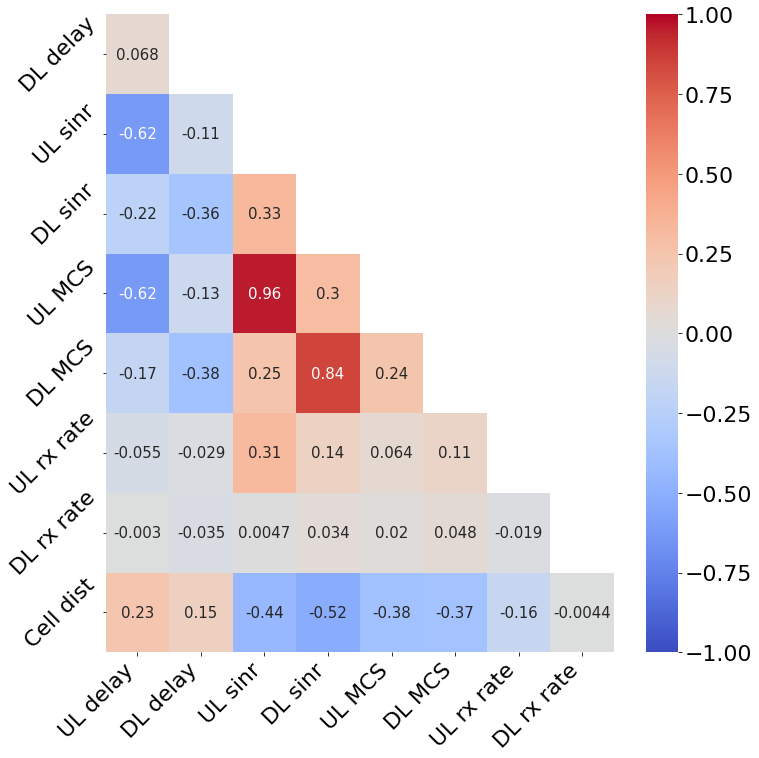

1000 500
1000 500
1000 500
1000 500
1000 500
1000 500
1000 500
1000 500
1000 500


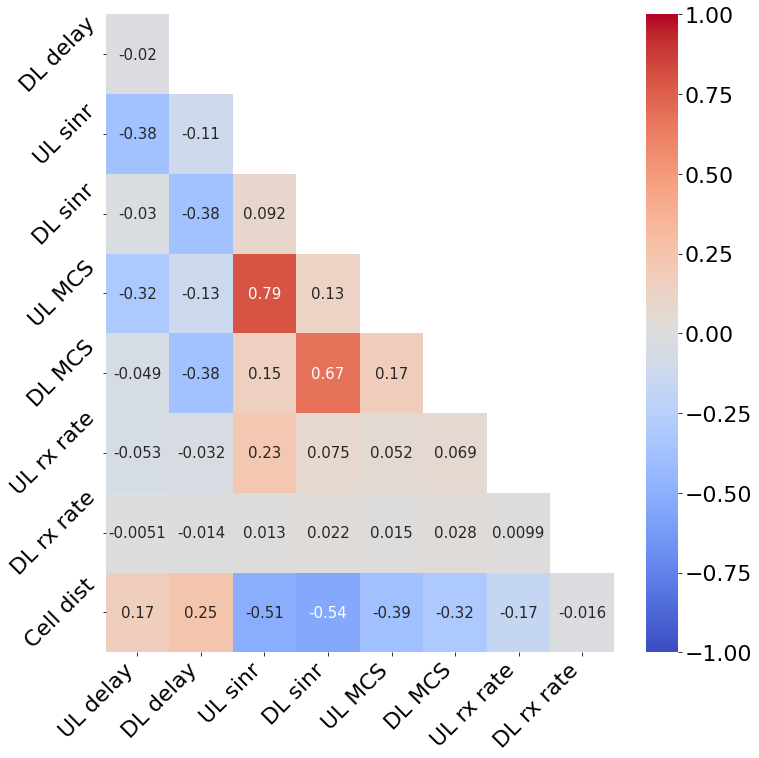

In [13]:
plt.rcParams["figure.autolayout"] = True
separate_macro_micro = True

def plot_heatmap(windowed_combined_data, plot_name):
    corr_data = windowed_combined_data.corr(method='spearman')
    fig = plt.figure(figsize=(11,11))
    mask = np.triu(np.ones_like(corr_data, dtype=bool))
    mask = mask[1:, :-1]
    corr = corr_data.iloc[1:,:-1].copy()
    hmap = sns.heatmap(corr, vmin=-1, cmap='coolwarm', annot=True, mask=mask, 
                       vmax=1, annot_kws={"fontsize":15}, linecolor='black')
    fig = hmap.get_figure()
    plt.yticks(rotation=45)
    fig.autofmt_xdate(rotation=45)
    fname=plot_dir+plot_name
    plt.savefig(fname)
    plt.show()


# plot a heatmap  
#w_cell_ul_thput = out_mat = geek.matlib.repmat(in_arr, 1, total_num_ues) 

if separate_macro_micro:
    windowed_combined_data = pd.DataFrame({'UL delay': imsi_slice_data(macro_imsis, w_ul_delays), 
                                'DL delay':imsi_slice_data(macro_imsis, w_dl_delays),
                                'UL sinr':imsi_slice_data(macro_imsis, w_ul_sinr),
                                'DL sinr':imsi_slice_data(macro_imsis, w_dl_sinr), 
                                'UL MCS':imsi_slice_data(macro_imsis, w_ul_mcs),
                                'DL MCS':imsi_slice_data(macro_imsis, w_dl_mcs),
                                'UL rx rate':imsi_slice_data(macro_imsis, w_ul_pkt_rx),
                                'DL rx rate':imsi_slice_data(macro_imsis, w_dl_pkt_rx),
                                #'cell_ul_thput':cell_ul_thput,
                                #'cell_dl_thput':cell_dl_thput,
                                'Cell dist':imsi_slice_data(macro_imsis, w_dist_to_cell)
                                })
    plot_heatmap(windowed_combined_data, 'macro_heatmap.pdf')
    
    windowed_combined_data = pd.DataFrame({'UL delay': imsi_slice_data(micro_imsis, w_ul_delays), 
                                'DL delay':imsi_slice_data(micro_imsis, w_dl_delays),
                                'UL sinr':imsi_slice_data(micro_imsis, w_ul_sinr),
                                'DL sinr':imsi_slice_data(micro_imsis, w_dl_sinr), 
                                'UL MCS':imsi_slice_data(micro_imsis, w_ul_mcs),
                                'DL MCS':imsi_slice_data(micro_imsis, w_dl_mcs),
                                'UL rx rate':imsi_slice_data(micro_imsis, w_ul_pkt_rx),
                                'DL rx rate':imsi_slice_data(micro_imsis, w_dl_pkt_rx),
                                #'cell_ul_thput':cell_ul_thput,
                                #'cell_dl_thput':cell_dl_thput,
                                'Cell dist':imsi_slice_data(micro_imsis, w_dist_to_cell)
                                })
    plot_heatmap(windowed_combined_data, 'micro_heatmap.pdf')
    
else:
    windowed_combined_data = pd.DataFrame({'UL delay': w_ul_delays, 
                                'DL delay':w_dl_delays,
                                'UL sinr':w_ul_sinr,
                                'DL sinr':w_dl_sinr, 
                                'UL MCS':w_ul_mcs,
                                'DL MCS':w_dl_mcs,
                                'UL rx rate':w_ul_pkt_rx,
                                'DL rx rate':w_dl_pkt_rx,
                                #'cell_ul_thput':cell_ul_thput,
                                #'cell_dl_thput':cell_dl_thput,
                                'Cell dist':w_dist_to_cell
                                })
    plot_heatmap(windowed_combined_data, 'heatmap.pdf')

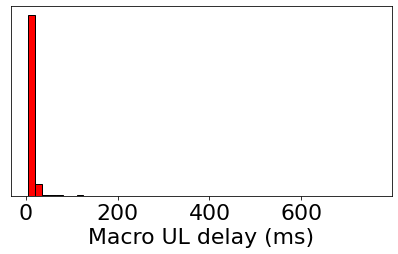

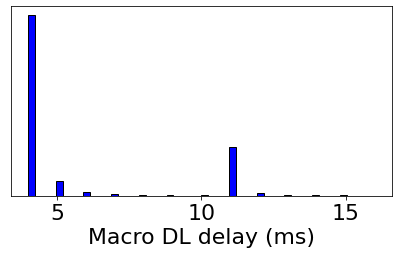

1000 500


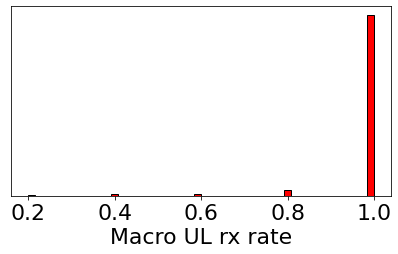

1000 500


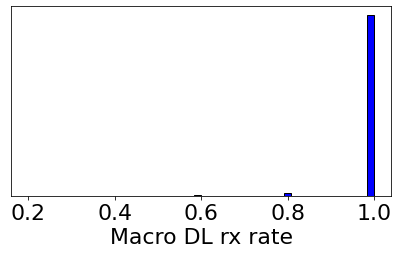

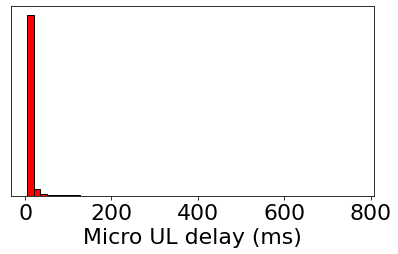

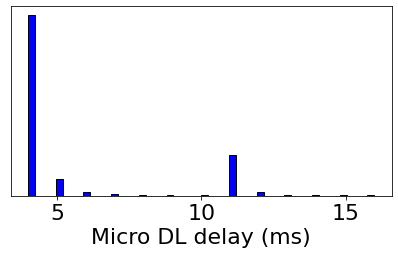

1000 500


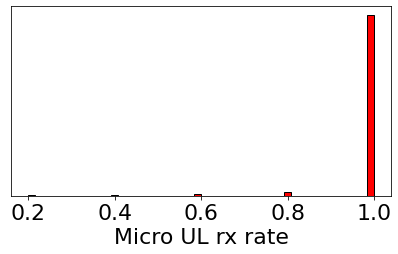

1000 500


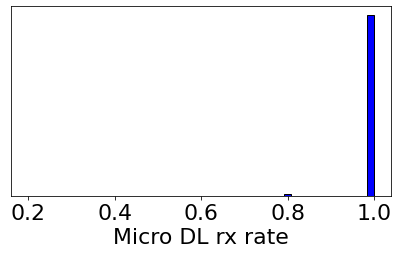

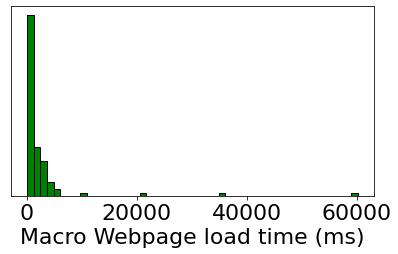

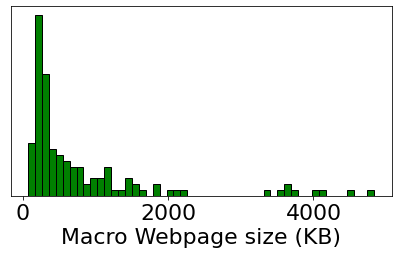

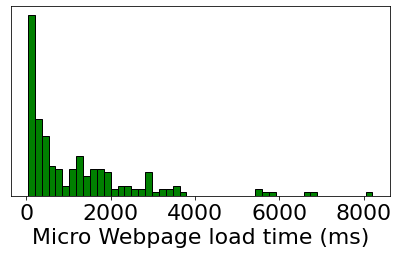

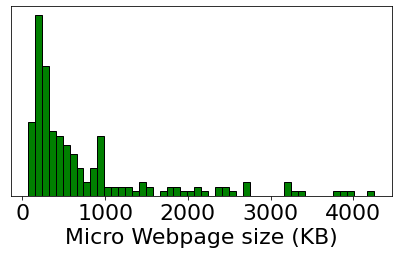

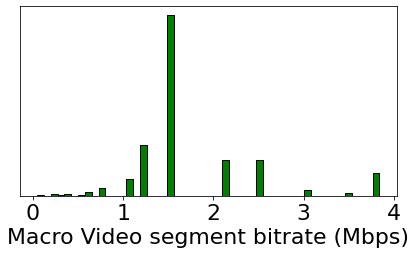

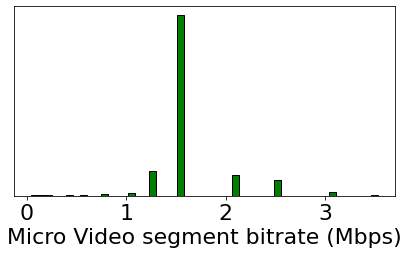

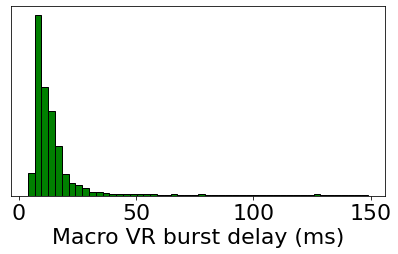

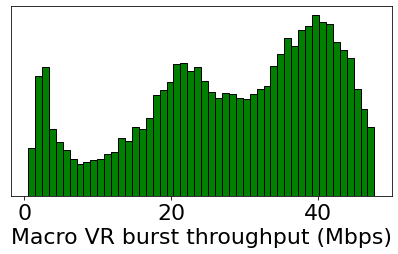

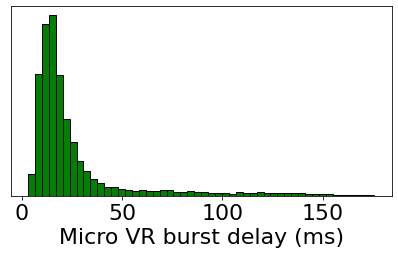

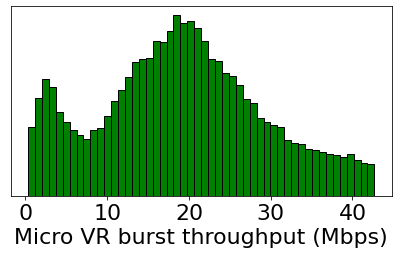

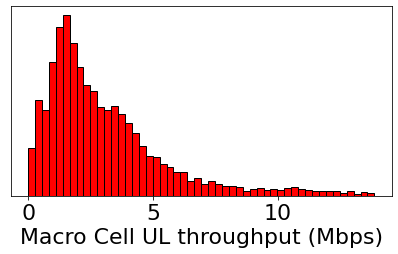

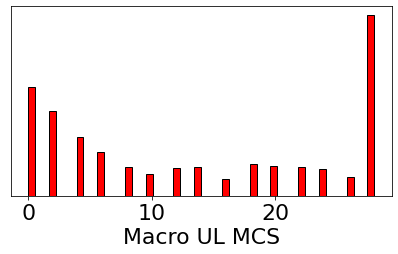

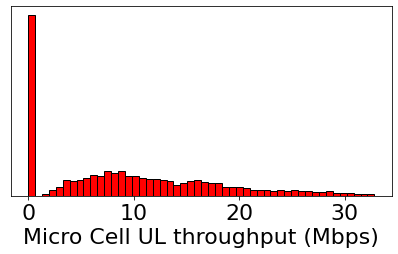

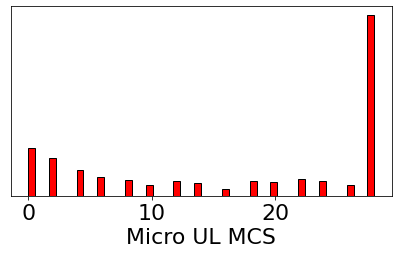

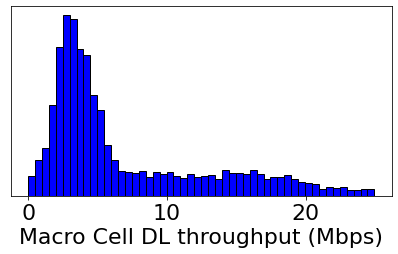

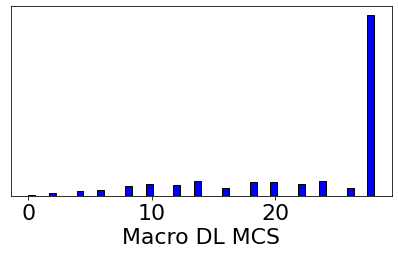

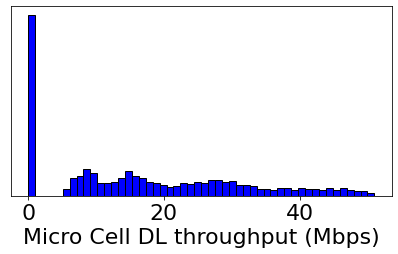

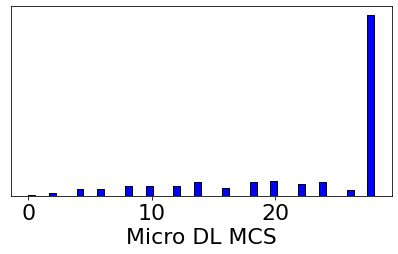

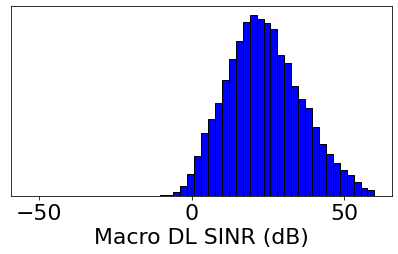

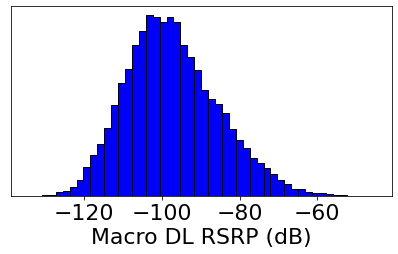

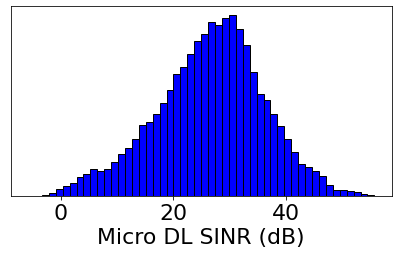

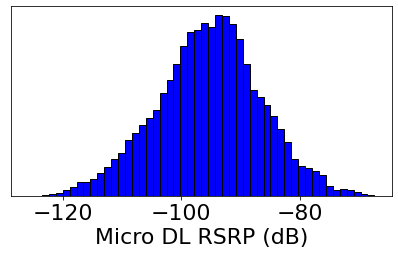

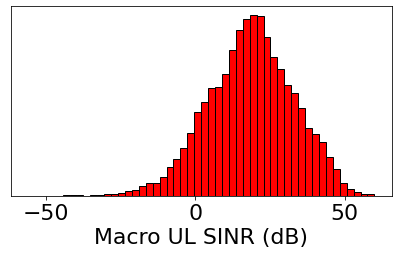

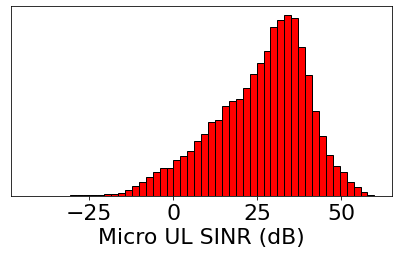

1000 500


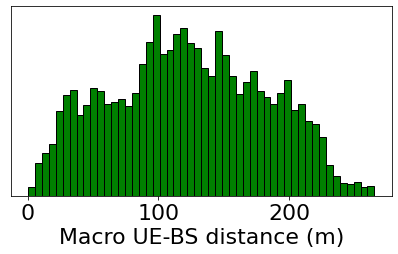

1000 500


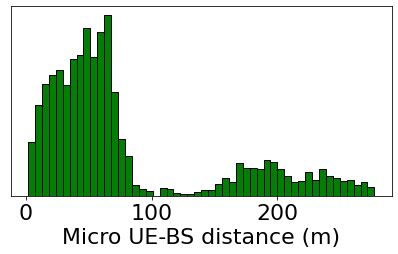

In [14]:
separate_macro_micro = True
#=======================================
# Plot histograms   
#=======================================
# for metrics related to delay we are removing outliers using the 99th percentile value so that we can 
# get a better view of what is happenning in the data        
    
if separate_macro_micro:    
    if ('delay_trace.txt' in files):
        #plot_histogram_xlim(ul_delays['macro'], 'red', 'Macro UL delay (ms)', 'macro_hist_ul_delays.pdf', plot_dir, [0,500])
        #plot_histogram_xlim(dl_delays['macro'], 'blue', 'Macro DL delay (ms)', 'macro_hist_dl_delays.pdf', plot_dir, [0,500])
        plot_histogram(ul_delays['macro'], 'red', 'Macro UL delay (ms)', 'macro_hist_ul_delays.pdf', plot_dir)
        plot_histogram(dl_delays['macro'], 'blue', 'Macro DL delay (ms)', 'macro_hist_dl_delays.pdf', plot_dir)
        
        plot_histogram_xlim(imsi_slice_data(macro_imsis, w_ul_pkt_rx), 'red', 'Macro UL rx rate', 'macro_hist_ul_pkt_rx.pdf', plot_dir, [0,1])
        plot_histogram_xlim(imsi_slice_data(macro_imsis, w_dl_pkt_rx), 'blue', 'Macro DL rx rate', 'macro_hist_dl_pkt_rx.pdf', plot_dir, [0,1])
        
        #plot_histogram_xlim(ul_delays['micro'], 'red', 'Micro UL delay (ms)', 'micro_hist_ul_delays.pdf', plot_dir, [0,500])
        #plot_histogram_xlim(dl_delays['micro'], 'blue', 'Micro DL delay (ms)', 'micro_hist_dl_delays.pdf', plot_dir, [0,500])
        plot_histogram(ul_delays['micro'], 'red', 'Micro UL delay (ms)', 'micro_hist_ul_delays.pdf', plot_dir)
        plot_histogram(dl_delays['micro'], 'blue', 'Micro DL delay (ms)', 'micro_hist_dl_delays.pdf', plot_dir)
        
        plot_histogram_xlim(imsi_slice_data(micro_imsis, w_ul_pkt_rx), 'red', 'Micro UL rx rate', 'micro_hist_ul_pkt_rx.pdf', plot_dir, [0,1])
        plot_histogram_xlim(imsi_slice_data(micro_imsis, w_dl_pkt_rx), 'blue', 'Micro DL rx rate', 'micro_hist_dl_pkt_rx.pdf', plot_dir, [0,1])
    #if ('rtt_trace.txt' in files):
    #    plot_histogram_xlim(rtt_delays['macro'], 'violet', 'Macro RTT delay (ms)', 'macro_hist_rtt_delays.pdf', plot_dir, [0,500])
    #    plot_histogram_xlim(rtt_delays['micro'], 'violet', 'Micro RTT delay (ms)', 'micro_hist_rtt_delays.pdf', plot_dir, [0,500])
    if ('httpClientRtt_trace.txt' in files):
        plot_histogram(page_load_time['macro'], 'green', 'Macro Webpage load time (ms)', 'macro_hist_page_load_time.pdf', plot_dir)
        plot_histogram(webpage_size['macro'], 'green', 'Macro Webpage size (KB)', 'macro_hist_webpage_size.pdf', plot_dir)
        
        plot_histogram(page_load_time['micro'], 'green', 'Micro Webpage load time (ms)', 'micro_hist_page_load_time.pdf', plot_dir)
        plot_histogram(webpage_size['micro'], 'green', 'Micro Webpage size (KB)', 'micro_hist_webpage_size.pdf', plot_dir)
    if ('dashClient_trace.txt' in files): 
        plot_histogram(segment_bitrate['macro']/M, 'green', 'Macro Video segment bitrate (Mbps)', 'macro_hist_segment_bitrate.pdf', plot_dir)
        
        plot_histogram(segment_bitrate['micro']/M, 'green', 'Micro Video segment bitrate (Mbps)', 'micro_hist_segment_bitrate.pdf', plot_dir)
    if ('vrFragment_trace.txt' in files): 
        plot_histogram(vr_burst_time['macro'], 'green', 'Macro VR burst delay (ms)', 'macro_hist_vr_burst_time.pdf', plot_dir)
        plot_histogram(vr_burst_thput['macro'], 'green', 'Macro VR burst throughput (Mbps)', 'macro_hist_vr_burst_thput.pdf', plot_dir)
        
        plot_histogram(vr_burst_time['micro'], 'green', 'Micro VR burst delay (ms)', 'micro_hist_vr_burst_time.pdf', plot_dir)
        plot_histogram(vr_burst_thput['micro'], 'green', 'Micro VR burst throughput (Mbps)', 'micro_hist_vr_burst_thput.pdf', plot_dir)
    if ('UlMacStats.txt' in files):
        plot_histogram(cell_ul_thput['macro'], 'red', 'Macro Cell UL throughput (Mbps)', 'macro_hist_cell_ul_thput.pdf', plot_dir)
        plot_histogram(ul_mcs['macro'], 'red', 'Macro UL MCS', 'macro_hist_ul_mcs.pdf', plot_dir)
        
        plot_histogram(cell_ul_thput['micro'], 'red', 'Micro Cell UL throughput (Mbps)', 'micro_hist_cell_ul_thput.pdf', plot_dir)
        plot_histogram(ul_mcs['micro'], 'red', 'Micro UL MCS', 'micro_hist_ul_mcs.pdf', plot_dir)
    if ('DlMacStats.txt' in files): 
        plot_histogram(cell_dl_thput['macro'], 'blue', 'Macro Cell DL throughput (Mbps)', 'macro_hist_cell_dl_thput.pdf', plot_dir)
        plot_histogram(dl_mcs['macro'], 'blue', 'Macro DL MCS', 'macro_hist_dl_mcs.pdf', plot_dir)
        
        plot_histogram(cell_dl_thput['micro'], 'blue', 'Micro Cell DL throughput (Mbps)', 'micro_hist_cell_dl_thput.pdf', plot_dir)
        plot_histogram(dl_mcs['micro'], 'blue', 'Micro DL MCS', 'micro_hist_dl_mcs.pdf', plot_dir)
    if ('DlRsrpSinrStats.txt' in files):
        plot_histogram_xlim(10*np.log10(dl_sinr['macro']), 'blue', 'Macro DL SINR (dB)', 'macro_hist_dl_sinr.pdf', plot_dir, [-60,60])
        plot_histogram_xlim(10*np.log10(1000*dl_rsrp['macro']), 'blue', 'Macro DL RSRP (dB)', 'macro_hist_dl_rsrp.pdf', plot_dir, [-140,40])
        
        plot_histogram_xlim(10*np.log10(dl_sinr['micro']), 'blue', 'Micro DL SINR (dB)', 'micro_hist_dl_sinr.pdf', plot_dir, [-60,60])
        plot_histogram_xlim(10*np.log10(1000*dl_rsrp['micro']), 'blue', 'Micro DL RSRP (dB)', 'micro_hist_dl_rsrp.pdf', plot_dir, [-140,40])
    if ('UlSinrStats.txt' in files):
        plot_histogram_xlim(10*np.log10(ul_sinr['macro']), 'red', 'Macro UL SINR (dB)', 'macro_hist_ul_sinr.pdf', plot_dir, [-60,60])
        
        plot_histogram_xlim(10*np.log10(ul_sinr['micro']), 'red', 'Micro UL SINR (dB)', 'micro_hist_ul_sinr.pdf', plot_dir, [-60,60])
    if ('mobility_trace.txt' in files): 
        plot_histogram(imsi_slice_data(macro_imsis, w_dist_to_cell), 'green', 'Macro UE-BS distance (m)', 'macro_hist_ue_bs_dist.pdf', plot_dir)
        
        plot_histogram(imsi_slice_data(micro_imsis, w_dist_to_cell), 'green', 'Micro UE-BS distance (m)', 'micro_hist_ue_bs_dist.pdf', plot_dir)
            
else:
        if ('delay_trace.txt' in files):
            plot_histogram_xlim(np.append(ul_delays['macro'], ul_delays['micro']), 'red', 'UL delay (ms)', 'hist_ul_delays.pdf', plot_dir, [0,500])
            plot_histogram_xlim(np.append(dl_delays['macro'], dl_delays['micro']), 'blue', 'DL delay (ms)', 'hist_dl_delays.pdf', plot_dir, [0,500])
            plot_histogram_xlim(w_ul_pkt_rx, 'red', 'UL rx rate', 'hist_ul_pkt_rx.pdf', plot_dir, [0,1])
            plot_histogram_xlim(w_dl_pkt_rx, 'blue', 'DL rx rate', 'hist_dl_pkt_rx.pdf', plot_dir, [0,1])    
        #if ('rtt_trace.txt' in files):
        #    plot_histogram_xlim(rtt_delays['macro'], 'violet', 'Macro RTT delay (ms)', 'macro_hist_rtt_delays.pdf', plot_dir, [0,500])
        if ('httpClientRtt_trace.txt' in files):
            plot_histogram(np.append(page_load_time['macro'], page_load_time['micro']), 'green', 'Webpage load time (ms)', 'hist_page_load_time.pdf', plot_dir)
        if ('httpClientRtt_trace.txt' in files):
            plot_histogram(np.append(webpage_size['macro'], webpage_size['micro']), 'green', 'Webpage size (KB)', 'hist_webpage_size.pdf', plot_dir)
        if ('dashClient_trace.txt' in files): 
            plot_histogram(np.append(segment_bitrate['macro']/M, segment_bitrate['micro']/M), 'green', 'Video segment bitrate (Mbps)', 'hist_segment_bitrate.pdf', plot_dir)
        if ('vrFragment_trace.txt' in files): 
            plot_histogram(np.append(vr_burst_time['macro'], vr_burst_time['micro']), 'green', 'VR burst delay (ms)', 'hist_vr_burst_time.pdf', plot_dir)
            plot_histogram(np.append(vr_burst_thput['macro'], vr_burst_thput['micro']), 'green', 'VR burst throughput (Mbps)', 'hist_vr_burst_thput.pdf', plot_dir)
        if ('UlMacStats.txt' in files):
            plot_histogram(np.append(cell_ul_thput['macro'], cell_ul_thput['micro']), 'red', 'Cell UL throughput (Mbps)', 'hist_cell_ul_thput.pdf', plot_dir)
        if ('DlMacStats.txt' in files): 
            plot_histogram(np.append(cell_dl_thput['macro'], cell_dl_thput['micro']), 'blue', 'Cell DL throughput (Mbps)', 'hist_cell_dl_thput.pdf', plot_dir)
        if ('DlRsrpSinrStats.txt' in files):
            plot_histogram_xlim(np.append(10*np.log10(dl_sinr['macro']), 10*np.log10(dl_sinr['micro'])), 'blue', 'DL SINR (dB)', 'hist_dl_sinr.pdf', plot_dir, [-60,60])
            plot_histogram_xlim(np.append(10*np.log10(1000*dl_rsrp['macro']), 10*np.log10(1000*dl_rsrp['micro'])), 'blue', 'DL RSRP (dB)', 'hist_dl_rsrp.pdf', plot_dir, [-140,40])
        if ('UlSinrStats.txt' in files):
            plot_histogram_xlim(np.append(10*np.log10(ul_sinr['macro']), 10*np.log10(ul_sinr['micro'])), 'red', 'UL SINR (dB)', 'hist_ul_sinr.pdf', plot_dir, [-60,60])
        if ('UlMacStats.txt' in files): 
            plot_histogram(np.append(ul_mcs['macro'], ul_mcs['micro']), 'red', 'UL MCS', 'hist_ul_mcs.pdf', plot_dir)
        if ('DlMacStats.txt' in files): 
            plot_histogram(np.append(dl_mcs['macro'], dl_mcs['micro']), 'blue', 'DL MCS', 'hist_dl_mcs.pdf', plot_dir)
        if ('mobility_trace.txt' in files): 
            plot_histogram(w_dist_to_cell, 'green', 'UE-BS distance (m)', 'hist_ue_bs_dist.pdf', plot_dir)


1000 500
1000 500


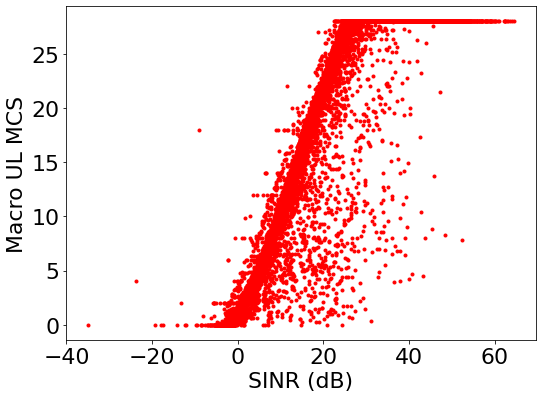

1000 500
1000 500


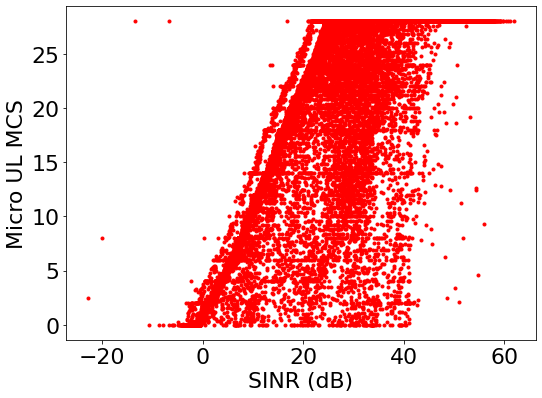

1000 500
1000 500


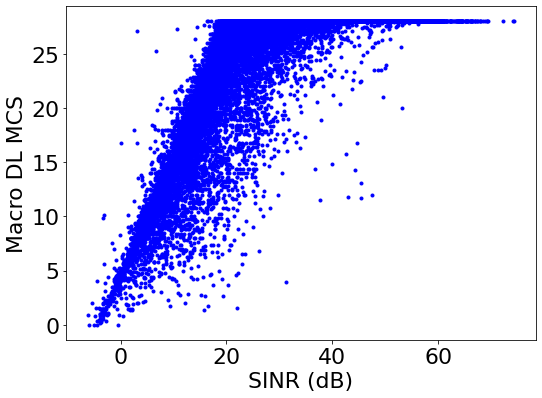

1000 500
1000 500


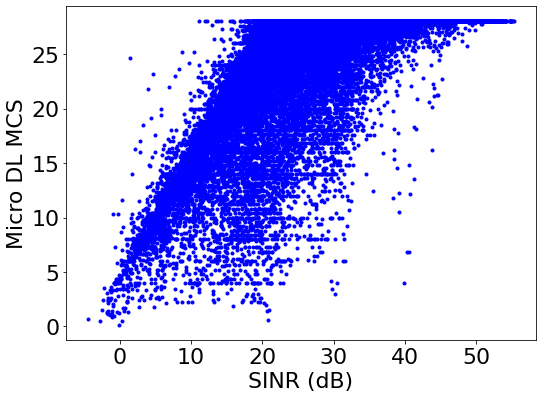

1000 500
1000 500


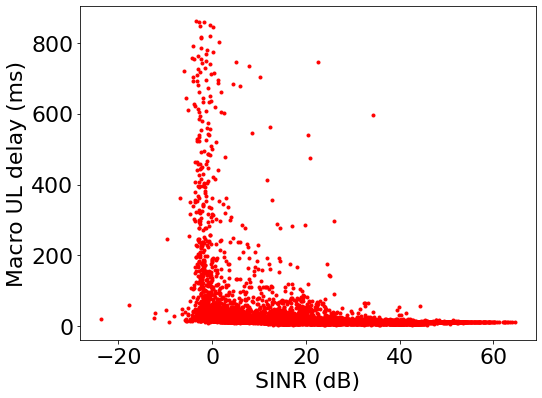

1000 500
1000 500


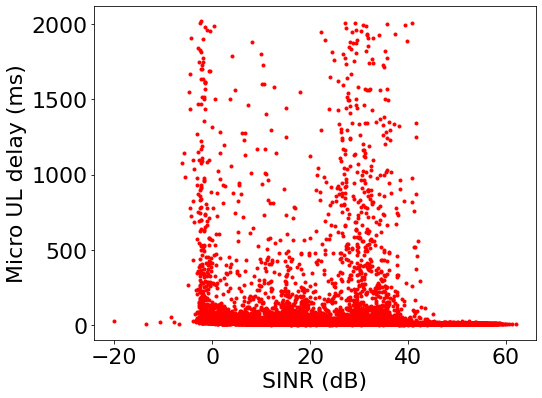

1000 500
1000 500


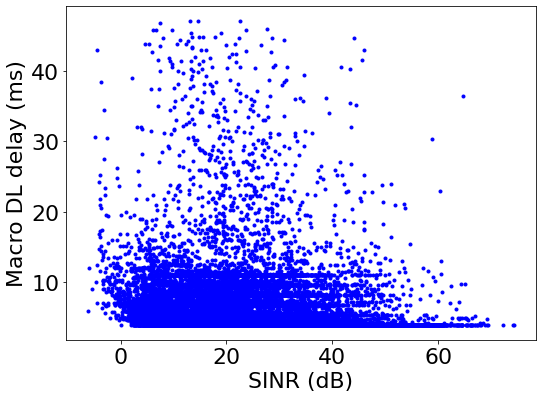

1000 500
1000 500


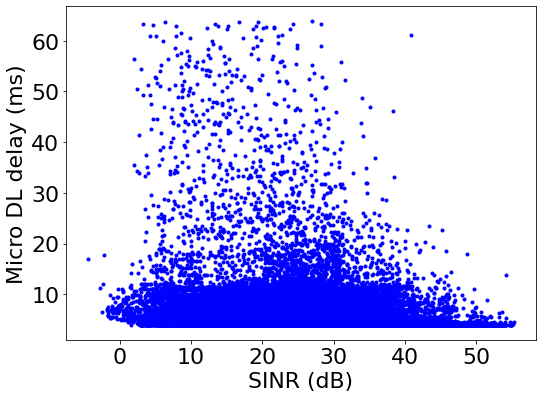

1000 500
1000 500


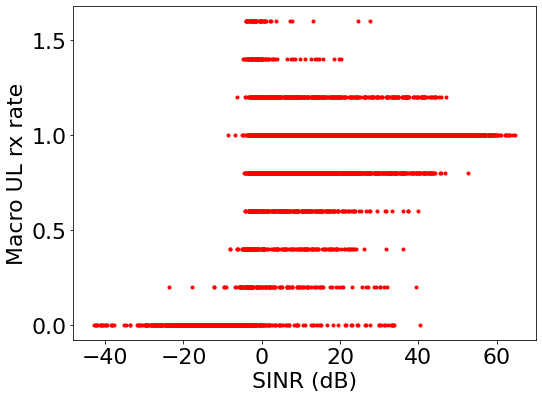

1000 500
1000 500


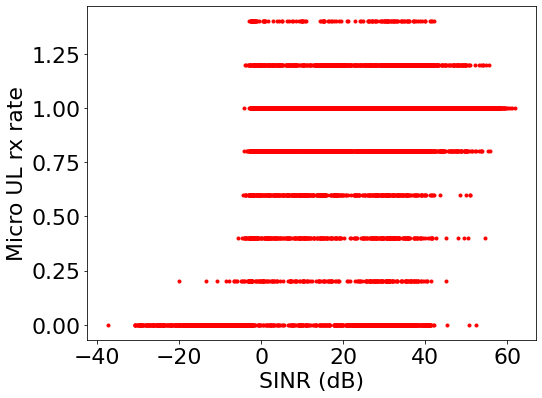

1000 500
1000 500


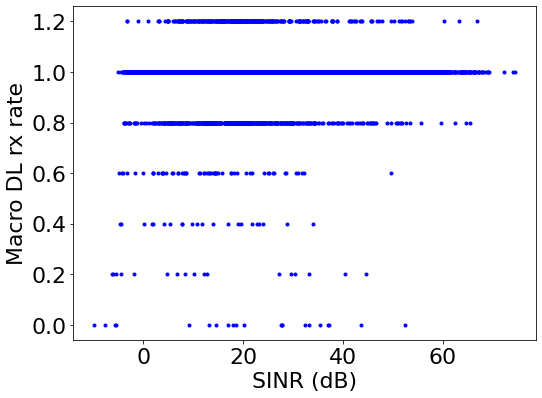

1000 500
1000 500


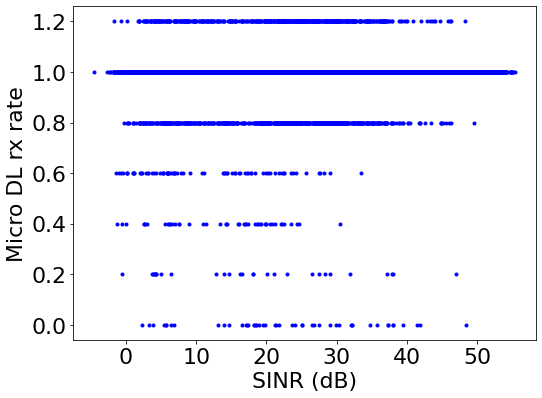

In [11]:
#=======================================
# Plot metrics vs SINR   
#=======================================


if separate_macro_micro:
    if ('UlMacStats.txt' in files) and ('DlMacStats.txt' in files):
        plot_metric_vs_sinr(imsi_slice_data(macro_imsis, 10*np.log10(w_ul_sinr)), imsi_slice_data(macro_imsis, w_ul_mcs), 'red', 'Macro UL MCS', 'ul_sinr_vs_mcs.pdf', plot_dir)
        plot_metric_vs_sinr(imsi_slice_data(micro_imsis, 10*np.log10(w_ul_sinr)), imsi_slice_data(micro_imsis, w_ul_mcs), 'red', 'Micro UL MCS', 'ul_sinr_vs_mcs.pdf', plot_dir)

        plot_metric_vs_sinr(imsi_slice_data(macro_imsis, 10*np.log10(w_dl_sinr)), imsi_slice_data(macro_imsis, w_dl_mcs), 'blue', 'Macro DL MCS', 'dl_sinr_vs_mcs.pdf', plot_dir)
        plot_metric_vs_sinr(imsi_slice_data(micro_imsis, 10*np.log10(w_dl_sinr)), imsi_slice_data(micro_imsis, w_dl_mcs), 'blue', 'Micro DL MCS', 'dl_sinr_vs_mcs.pdf', plot_dir)
    
    if ('delay_trace.txt' in files):
        plot_metric_vs_sinr(imsi_slice_data(macro_imsis, 10*np.log10(w_ul_sinr)), imsi_slice_data(macro_imsis, w_ul_delays), 'red', 'Macro UL delay (ms)', 'ul_sinr_vs_delay.pdf', plot_dir)
        plot_metric_vs_sinr(imsi_slice_data(micro_imsis, 10*np.log10(w_ul_sinr)), imsi_slice_data(micro_imsis, w_ul_delays), 'red', 'Micro UL delay (ms)', 'ul_sinr_vs_delay.pdf', plot_dir)
        
        plot_metric_vs_sinr(imsi_slice_data(macro_imsis, 10*np.log10(w_dl_sinr)), imsi_slice_data(macro_imsis, w_dl_delays), 'blue', 'Macro DL delay (ms)', 'dl_sinr_vs_delay.pdf', plot_dir)
        plot_metric_vs_sinr(imsi_slice_data(micro_imsis, 10*np.log10(w_dl_sinr)), imsi_slice_data(micro_imsis, w_dl_delays), 'blue', 'Micro DL delay (ms)', 'dl_sinr_vs_delay.pdf', plot_dir)
        
        plot_metric_vs_sinr(imsi_slice_data(macro_imsis, 10*np.log10(w_ul_sinr)), imsi_slice_data(macro_imsis, w_ul_pkt_rx), 'red', 'Macro UL rx rate', 'ul_sinr_vs_ul_pkt_rx.pdf', plot_dir)
        plot_metric_vs_sinr(imsi_slice_data(micro_imsis, 10*np.log10(w_ul_sinr)), imsi_slice_data(micro_imsis, w_ul_pkt_rx), 'red', 'Micro UL rx rate', 'ul_sinr_vs_ul_pkt_rx.pdf', plot_dir)
        
        plot_metric_vs_sinr(imsi_slice_data(macro_imsis, 10*np.log10(w_dl_sinr)), imsi_slice_data(macro_imsis, w_dl_pkt_rx), 'blue', 'Macro DL rx rate', 'dl_sinr_vs_dl_pkt_rx.pdf', plot_dir)
        plot_metric_vs_sinr(imsi_slice_data(micro_imsis, 10*np.log10(w_dl_sinr)), imsi_slice_data(micro_imsis, w_dl_pkt_rx), 'blue', 'Micro DL rx rate', 'dl_sinr_vs_dl_pkt_rx.pdf', plot_dir)        
else:
    if ('UlMacStats.txt' in files) and ('DlMacStats.txt' in files):
        plot_metric_vs_sinr(10*np.log10(w_ul_sinr), w_ul_mcs, 'red', 'Macro UL MCS', 'ul_sinr_vs_mcs.pdf', plot_dir)
        plot_metric_vs_sinr(10*np.log10(w_dl_sinr), w_dl_mcs, 'blue', 'Macro DL MCS', 'dl_sinr_vs_mcs.pdf', plot_dir)
        
    if ('delay_trace.txt' in files):
        plot_metric_vs_sinr(10*np.log10(w_ul_sinr), w_ul_delays, 'red', 'UL delay (ms)', 'ul_sinr_vs_delay.pdf', plot_dir)
        plot_metric_vs_sinr(10*np.log10(w_dl_sinr), w_dl_delays, 'blue', 'DL delay (ms)', 'dl_sinr_vs_delay.pdf', plot_dir)
        plot_metric_vs_sinr(10*np.log10(w_ul_sinr), w_ul_pkt_rx, 'red', 'UL rx rate', 'ul_sinr_vs_ul_pkt_rx.pdf', plot_dir)
        plot_metric_vs_sinr(10*np.log10(w_dl_sinr), w_dl_pkt_rx, 'blue', 'DL rx rate', 'dl_sinr_vs_dl_pkt_rx.pdf', plot_dir)


    
    #fig = plt.figure(figsize=(10,10))
    #plt.plot(10*np.log10(w_dl_sinr), 10*np.log10(w_ul_sinr), '.', color='k')
    #plt.xlabel('DL SINR'); plt.ylabel('UL SINR'); 
    #fname=plot_dir+'ul_vs_dl_sinr.pdf'
    #plt.savefig(fname)
    #plt.show()
    


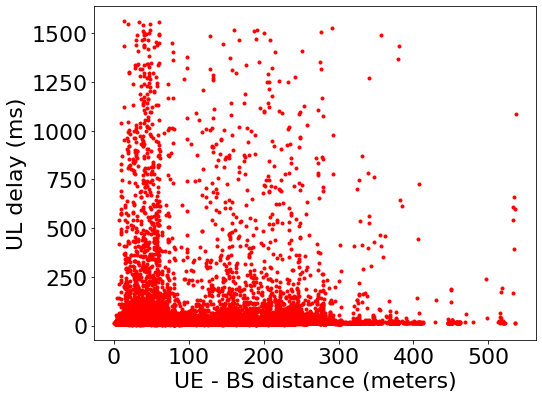

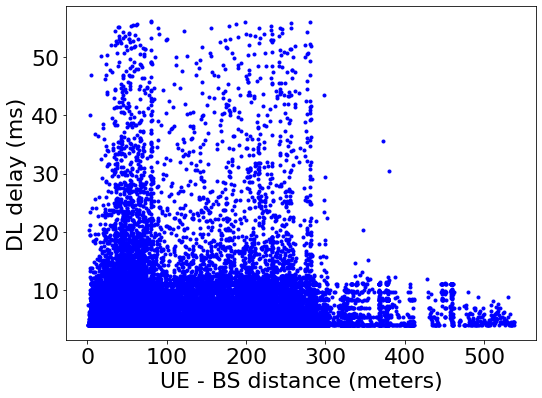

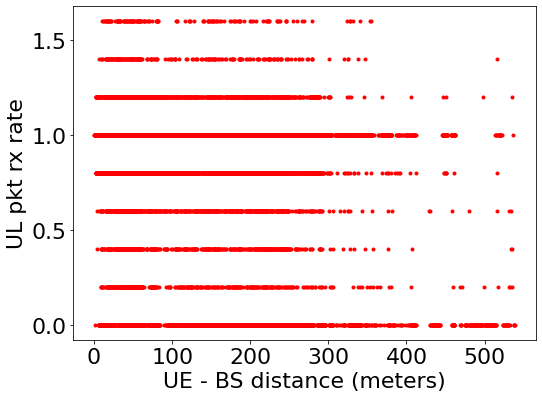

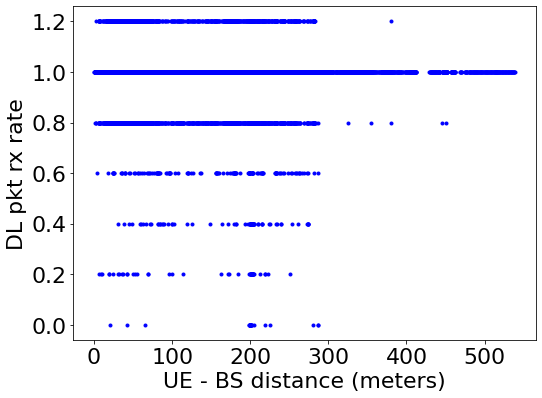

1000 500
1000 500


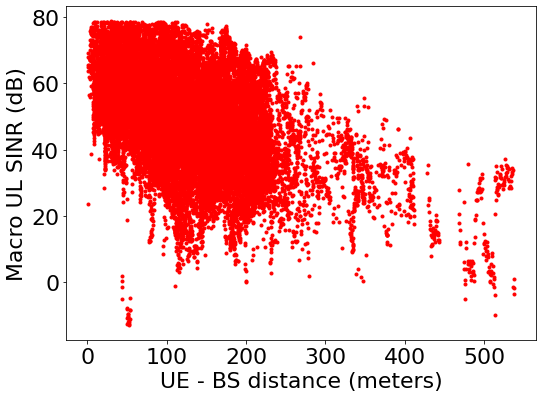

1000 500
1000 500


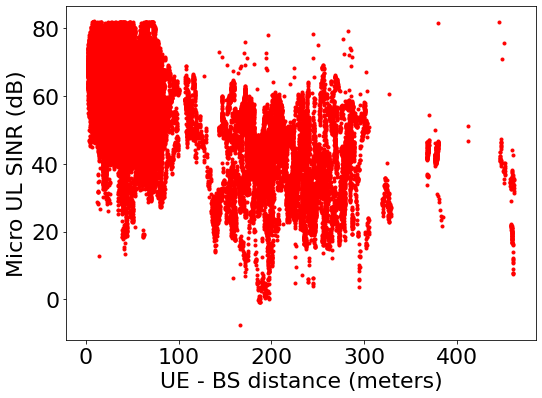

1000 500
1000 500


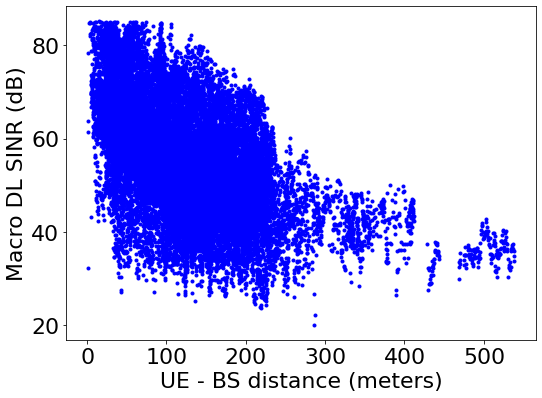

1000 500
1000 500


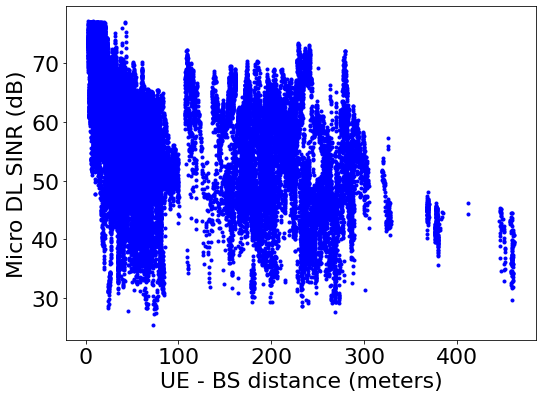

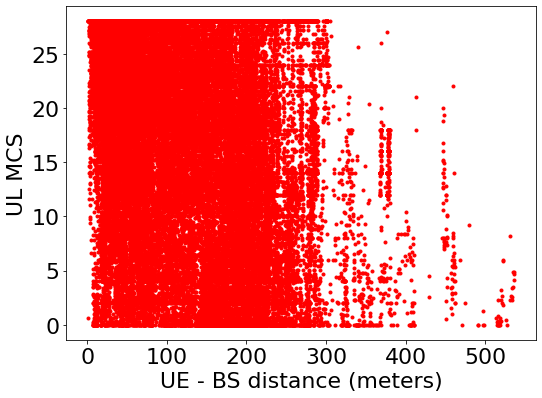

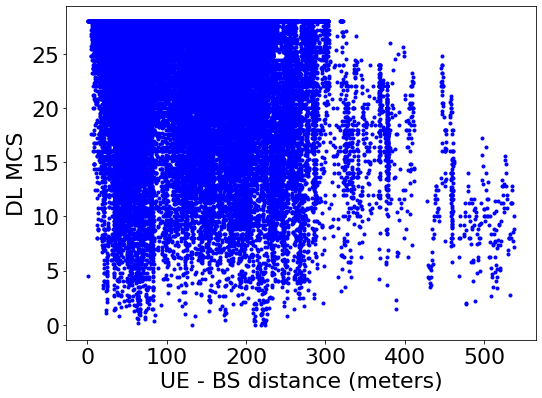

DONE


In [12]:
  
#=======================================
# Plot metrics vs UE-BS distance   
#======================================= 
if distance_plots:
    #print('Each plot with sample size: ', w_dist_to_cell.size)
    if ('delay_trace.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_ul_delays, 'red', 'UL delay (ms)', 'dist_vs_ul_delay.pdf', plot_dir)
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_dl_delays, 'blue', 'DL delay (ms)', 'dist_vs_dl_delay.pdf', plot_dir)
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_ul_pkt_rx, 'red', 'UL pkt rx rate', 'dist_vs_ul_pkt_rx.pdf', plot_dir)
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_dl_pkt_rx, 'blue', 'DL pkt rx rate', 'dist_vs_dl_pkt_rx.pdf', plot_dir)
        
    #if ('rtt_trace.txt' in files):       
        #plot_metric_vs_distance_to_cell(w_dist_to_cell, w_rtt_delays, 'violet', 'RTT delay (ms)', 'dist_vs_rtt_delay.pdf', plot_dir)
    if ('ulThroughput_trace.txt' in files):
        #for a single user since only one user measures throughput
        imsi=1  
        imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        imsi_sliced_y = ul_thput[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'red', 'UL throughput (Mbps)', 'dist_vs_ul_thput.pdf', plot_dir)
        #plot_metric_vs_distance_to_cell(w_dist_to_cell, ul_thput, 'red', 'UL throughput (Mbps)', 'dist_vs_ul_thput.pdf', plot_dir)
    if ('dlThroughput_trace.txt' in files):
        #for a single user since only one user measures throughput
        imsi=1  
        imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        imsi_sliced_y = dl_thput[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        
        plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'blue', 'DL throughput (Mbps)', 'dist_vs_dl_thput.pdf', plot_dir)
        #plot_metric_vs_distance_to_cell(w_dist_to_cell, dl_thput, 'blue', 'DL throughput (Mbps)', 'dist_vs_dl_thput.pdf', plot_dir)
    if ('UlSinrStats.txt' in files):       
        plot_metric_vs_distance_to_cell(imsi_slice_data(macro_imsis, w_dist_to_cell), imsi_slice_data(macro_imsis, 10*np.log10(1000*w_ul_sinr)), 'red', 'Macro UL SINR (dB)', 'dist_vs_ul_sinr.pdf', plot_dir)
        plot_metric_vs_distance_to_cell(imsi_slice_data(micro_imsis, w_dist_to_cell), imsi_slice_data(micro_imsis, 10*np.log10(1000*w_ul_sinr)), 'red', 'Micro UL SINR (dB)', 'dist_vs_ul_sinr.pdf', plot_dir)
        
        # for a single user 
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = 10*np.log10(w_ul_sinr[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ])
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'red', 'UL SINR (dB)', 'dist_vs_ul_sinr.pdf', plot_dir)
    if ('DlRsrpSinrStats.txt' in files):  
        plot_metric_vs_distance_to_cell(imsi_slice_data(macro_imsis, w_dist_to_cell), imsi_slice_data(macro_imsis, 10*np.log10(1000*w_dl_sinr)), 'blue', 'Macro DL SINR (dB)', 'dist_vs_dl_sinr.pdf', plot_dir)
        plot_metric_vs_distance_to_cell(imsi_slice_data(micro_imsis, w_dist_to_cell), imsi_slice_data(micro_imsis, 10*np.log10(1000*w_dl_sinr)), 'blue', 'Micro DL SINR (dB)', 'dist_vs_dl_sinr.pdf', plot_dir)
        
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = 10*np.log10(w_dl_sinr[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ])
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'blue', 'DL SINR (dB)', 'dist_vs_dl_sinr.pdf', plot_dir)
    if ('UlMacStats.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_ul_mcs, 'red', 'UL MCS', 'dist_vs_ul_mcs.pdf', plot_dir)
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = w_ul_mcs[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'red', 'UL MCS', 'dist_vs_ul_mcs.pdf', plot_dir)
    if ('DlMacStats.txt' in files):
        plot_metric_vs_distance_to_cell(w_dist_to_cell, w_dl_mcs, 'blue', 'DL MCS', 'dist_vs_dl_mcs.pdf', plot_dir)
        #imsi=1  
        #imsi_sliced_x = w_dist_to_cell[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #imsi_sliced_y = w_dl_mcs[int((imsi-1)*(sim_time*1000/time_wind_val)) : int(imsi*(sim_time*1000/time_wind_val)-1)  ]
        #plot_metric_vs_distance_to_cell(imsi_sliced_x, imsi_sliced_y, 'blue', 'DL MCS', 'dist_vs_dl_mcs.pdf', plot_dir)
        
            
print('DONE')
#wandb.finish    

In [19]:
import seaborn as sns
from matplotlib import cm, colors
from random import randint
from random import sample

ue_loc_file = 'mobility_trace.txt'
enb_loc_file = 'gnb_locations.txt'

In [20]:
# Specify here topology details from the dataset we are using
# When ISD = 500 m
#area_xlim=(-170,170)
#area_ylim=(-170,170)

area_xlim=(-250,250)
area_ylim=(-250,250)



# When ISD = 200 m 
#area_xlim=(-70,70)
#area_ylim=(-70,70)

clr_map=['r','b','g', 'cyan', 'magenta', 'gold']
bs_clr_map=['k', 'k', 'k', 'gray', 'gray', 'gray']

In [21]:
# When ISD = 500 m
#area_xlim=[-650,650]
#area_ylim=[-650,650]

# Creates a list of random colours to use 
#clr_map = []
#for i in range(total_num_cells):
#    clr_map.append('#%06X' % randint(0, 0xFFFFFF))

  0%|                                                                                                                                                                                                                                                              | 0/26 [00:00<?, ?it/s]

../../data_volume/30_11_power_1000_5_16/run21
../../data_volume/30_11_power_1000_5_16/run19
../../data_volume/30_11_power_1000_5_16/run25
../../data_volume/30_11_power_1000_5_16/run3
../../data_volume/30_11_power_1000_5_16/run6
../../data_volume/30_11_power_1000_5_16/run12
../../data_volume/30_11_power_1000_5_16/run8
../../data_volume/30_11_power_1000_5_16/run15
../../data_volume/30_11_power_1000_5_16/run5
../../data_volume/30_11_power_1000_5_16/run24
../../data_volume/30_11_power_1000_5_16/run18
../../data_volume/30_11_power_1000_5_16/run7
../../data_volume/30_11_power_1000_5_16/run20
../../data_volume/30_11_power_1000_5_16/run11
../../data_volume/30_11_power_1000_5_16/run10
../../data_volume/30_11_power_1000_5_16/run26
../../data_volume/30_11_power_1000_5_16/run22
   cellId  gnbpos_x      gnbpos_y  gnbpos_z
0       1       0.5  8.660250e-01        10
1       2      -1.0  1.224650e-16        10
2       3       0.5 -8.660250e-01        10
3       4    -100.0 -1.750000e+02         7
4  

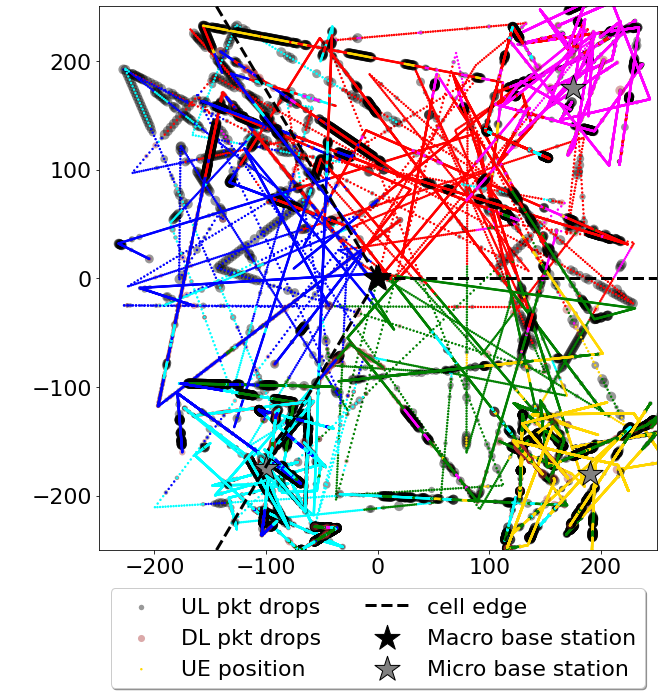

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:06<00:00,  3.93it/s]

../../data_volume/30_11_power_1000_5_16/run14
../../data_volume/30_11_power_1000_5_16/run17
../../data_volume/30_11_power_1000_5_16/run16
../../data_volume/30_11_power_1000_5_16/run9
../../data_volume/30_11_power_1000_5_16/run1
../../data_volume/30_11_power_1000_5_16/run13
../../data_volume/30_11_power_1000_5_16/run4
../../data_volume/30_11_power_1000_5_16/run23
../../data_volume/30_11_power_1000_5_16/run2


In [22]:
run_idx=0
for run in tqdm(use_runs_paths):    
    print('============================================================')
    print (run)
    print('============================================================')    
    only_run = run.split('/')[-1]
    if only_run in skip_runs:
        continue
    bs_locs = pd.read_csv(run+'/'+enb_loc_file, sep=',')
    print(bs_locs)
    bs_cellIds = bs_locs['cellId']
    bs_locs = bs_locs[['gnbpos_x', 'gnbpos_y']]
    # imsis chosen for plotting 
    #chosen_imsis=sample(range(1, total_num_ues+1), 30)
    chosen_imsis=range(1, total_num_ues+1)
    #chosen_imsis = micro_imsis 
    
    
    df = pd.read_csv(data_dir+run+'/'+ue_loc_file, sep='\t')
    
    samples_per_run_per_imsi = (sim_time*1000/time_wind_val) +1
    shift = run_idx*samples_per_run_per_imsi*total_num_ues
    #print('run start sample : ', int(shift))
    #print('run last sample : ', int(shift + (total_num_ues*samples_per_run_per_imsi-1)))
    ## Separate by UE
    #for name, df_ue in df.groupby(by=['IMSI']):
    df_ue=df.groupby(by=['IMSI'])
    
    fig = plt.figure(figsize=(10,10))
    
    for imsi in chosen_imsis:
        df_per_imsi=df_ue.get_group(imsi)
        #print(df_per_imsi['cellId'].value_counts())
        colors=[clr_map[cell-1] for cell in df_per_imsi['cellId'].to_numpy()]
        #w_ul_sinr
        #w_ul_mcs
        #print(ul_pkt_rx)
        #print(dl_pkt_rx)
        data = pd.DataFrame({'ue_x':w_avg_ue_xpos, 'ue_y':w_avg_ue_ypos, 'metric1':(1-w_ul_pkt_rx).clip(min=0), 'metric2':(1-w_dl_pkt_rx).clip(min=0), 
                             'metric3':(10*np.log10(w_ul_sinr)), 'metric4':(10*np.log10(w_dl_sinr))} )
        imsi_sliced_data = data[ int(shift + (imsi-1)*samples_per_run_per_imsi)  : int(shift + (imsi*samples_per_run_per_imsi-1))  ]
        # The lines indicating the cell edge 
        #fig = plt.figure(figsize=(10,10))    
        #if (imsi in only_delay_imsis) and (imsi not in vr_imsi):
            # plot the overlay metric 
        sns.scatterplot(data=imsi_sliced_data, x='ue_x', y='ue_y', size='metric1', legend=False, alpha=0.4, sizes=(0, 100), 
                        color='k', edgecolor='k')
        sns.scatterplot(data=imsi_sliced_data, x='ue_x', y='ue_y', size='metric2', legend=False, alpha=0.4, sizes=(0, 100), 
                        color='brown', edgecolor='brown')
        
        # plot the association as a colour
        plt.scatter(df_per_imsi['pos_x'], df_per_imsi['pos_y'], c=colors, s=2)
        #plt.title('IMSI: '+str(imsi))
    
    # just for the legend 
    sns.scatterplot(data=imsi_sliced_data, x='ue_x', y='ue_y', size='metric1', legend=False, alpha=0.4, sizes=(0, 100), 
                    color='k', edgecolor='k', label='UL pkt drops')
    sns.scatterplot(data=imsi_sliced_data, x='ue_x', y='ue_y', size='metric2', legend=False, alpha=0.4, sizes=(0, 100), 
                    color='brown', edgecolor='brown', label='DL pkt drops')
    # plot the association as a colour
    plt.scatter(df_per_imsi['pos_x'], df_per_imsi['pos_y'], c=colors, s=2, label='UE position')
    
    plt.plot([0, area_xlim[1]], [0, 0], 'k', linestyle="--", linewidth=3, label='cell edge')
    plt.plot([area_ylim[0]/math.sqrt(3), 0], [area_ylim[1], 0], 'k', linestyle="--", linewidth=3)
    plt.plot([area_ylim[0]/math.sqrt(3), 0], [area_ylim[0], 0], 'k', linestyle="--", linewidth=3)
    plt.xlim(area_xlim)
    plt.ylim(area_ylim)
    plt.xlabel(' ')
    plt.ylabel(' ')
    #plt.xlabel('X meters')
    #plt.ylabel('Y meters')
    ## plot base station locations
    plt.scatter(bs_locs['gnbpos_x'].iloc[0:3], bs_locs['gnbpos_y'].iloc[0:3], color='k', s=700, 
                label='Macro base station', marker='*', edgecolors='k')
    plt.scatter(bs_locs['gnbpos_x'].iloc[3:6], bs_locs['gnbpos_y'].iloc[3:6], color='gray', s=700, 
                label='Micro base station', marker='*', edgecolors='k')
    
        #plt.plot(bs_locs['gnbpos_x'], bs_locs['gnbpos_y'], color=bs_clr_map, linestyle="" , markersize=20, markeredgecolor='k', label='BS location', marker='*')
        #plt.legend(loc='upper right')
    #plt.text(bs_locs['gnbpos_x'], bs_locs['gnbpos_y'], bs_cellIds)    
    

    #plt.legend(loc='upper right')
    # Put a legend below current axis
    #box = plt.get_position()
    #plt.set_position([box.x0, box.y0 + box.height * 0.1,
    #             box.width, box.height * 0.9])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
    #plt.legend([, (red_dot, white_cross)], ["Attr A", "Attr A+B"])
    fname=plot_dir+only_run+'_mobility_trace.png'
    plt.savefig(fname, bbox_inches = 'tight')
    plt.show()
    run_idx=run_idx+1
    

In [66]:
import os
os.system('cp parse_visualize_data.ipynb '+'./saved_notebooks/'+data_dir.split('/')[-2]+'.ipynb')

0